In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 118.3 MB/s eta 0:00:00


In [ ]:
# Loading the modules
import matplotlib.pyplot as plt
import mne.time_frequency as mntf
#from mne.time_frequency import tfr_array_morlet
import numpy as np
import os
from scipy.fft import fft, fftfreq, ifft
from scipy.io import loadmat
from scipy.signal import iirnotch, filtfilt, freqz,welch, hilbert, detrend
from scipy.stats import shapiro, zscore
from sklearn.preprocessing import StandardScaler

### EEG Data Loading


---
The most standard EEG modalities arranged in order:


1.   Europen Data Format ( *.edf* ) and Matlab Data Format ( *.mat* )
2.   BrainVision Core Data Format ( *.vhdr* , *.vmrk* , *.eeg* )
3.   EEGLab ( *.set* , *.fdt* )
4.   Biosemni ( *.bdf* )

In [ ]:
MATdata = loadmat("/content/drive/MyDrive/Neuroinfo_Assignment/sampleEEGdata.mat")
#print(type(data))
print(MATdata.keys())

dict_keys(['__header__', '__version__', '__globals__', 'EEG'])


In [ ]:
eeg_struct = MATdata['EEG'][0, 0]
for name in MATdata['EEG'].dtype.names:
    print(f"{name}: {eeg_struct[name]}")

setname: ['EEG sample dataset']
filename: []
filepath: []
subject: []
group: []
condition: []
session: []
comments: ['Parent dataset: 15june2                                        '
 '                                                               '
 'Parent dataset "15june2": ----------                           '
 'Original file: /Users/mcohen1/Desktop/simondata/raw/15june2.bdf']
nbchan: [[64]]
trials: [[99]]
pnts: [[640]]
srate: [[256]]
xmin: [[-1]]
xmax: [[1.49609375]]
times: [[-1000.       -996.09375  -992.1875   -988.28125  -984.375    -980.46875
   -976.5625   -972.65625  -968.75     -964.84375  -960.9375   -957.03125
   -953.125    -949.21875  -945.3125   -941.40625  -937.5      -933.59375
   -929.6875   -925.78125  -921.875    -917.96875  -914.0625   -910.15625
   -906.25     -902.34375  -898.4375   -894.53125  -890.625    -886.71875
   -882.8125   -878.90625  -875.       -871.09375  -867.1875   -863.28125
   -859.375    -855.46875  -851.5625   -847.65625  -843.75     -839.843

In [ ]:
print(eeg_struct['times'].shape)
print(eeg_struct['data'].shape)
print(eeg_struct['chanlocs'].dtype.names)

(1, 640)
(64, 640, 99)
('labels', 'theta', 'radius', 'X', 'Y', 'Z', 'sph_theta', 'sph_phi', 'sph_radius', 'type', 'urchan')


In [ ]:
EEG = MATdata['EEG'][0,0]
data = EEG['data']
chanloc = EEG['chanlocs'][0]
chanloc_labels = chanloc['labels']
#print(chanloc_labels)
sampling_rate = EEG['srate'][0,0]
#print(sampling_rate)

### Matlab Code files (.m) reader

In [ ]:
with open('/content/drive/MyDrive/Neuroinfo_Assignment/matlabexercises/indexing.m', 'r') as file:
    matlab_code = file.read()

print(matlab_code)

% eeglab's EEG structure and indexing
% mikeXcohen@gmail.com

%% load in EEG data

load sampleEEGdata.mat

% FYI, this would also work:
% [file2load,path4file]=uigetfile('*.mat','Please select EEG data file');
% load([ path4file file2load ])

% take a minute to inspect the EEG structure
EEG

%% finding time indices based on ms

% The problem: We want to create a topographical plot at time=300 ms

time2plot = 300; % in ms!

% extract the trial-averaged data from requested time point
% (note: this code contains an error!)
data2plot = squeeze(mean( EEG.data(:,time2plot,:) ,3));


% plot
figure(1), clf
topoplot(data2plot,EEG.chanlocs);
title([ 'Topoplot from time=' num2str(EEG.times(time2plot)) ' ms.' ])

%% same concept for frequencies

frex = linspace(2,100,42);

freqIwant = 23; % in hz

% use min(abs trick to find closest frequency to 23 Hz
[~,frexidx] = min(abs(frex-freqIwant));

% the function dsearchn also works
frexidx = dsearchn(frex',freqIwant);

%% indexing channels based on name

In [ ]:
with open('/content/drive/MyDrive/Neuroinfo_Assignment/Assignment_1.m', 'r') as file:
    matlab_code = file.read()

print(matlab_code)

%% -------------------------
% Load EEG dataset
% -------------------------
eeglab
EEG = pop_loadset('eeglab_data.set', fullfile(fileparts(which('eeglab')), 'sample_data'));

data = EEG.data;       % channels x samples
chan_labels = {EEG.chanlocs.labels};

% -------------------------
% Step 1: Filtering: Notch filter at 60 Hz
% -------------------------
wo = 60/(EEG.srate/2); bo = wo/35;
[bn,an] = iirnotch(wo, bo);
data_filt = filtfilt(bn,an,data')';

% -------------------------
% Step 2: Plot PSD before & after filtering
% -------------------------
figure;
[~,~,~,~,~] = spectopo(data, size(data,2), EEG.srate);
figure;
[~,~,~,~,~] = spectopo(data_filt, size(data_filt,2), EEG.srate);

%% -------------------------
% Step 3: Referencing: Common Average Reference
% -------------------------
avg_ref = mean(data_filt, 1);
data_car = data_filt - avg_ref;

%% -------------------------
% Step 4: Epoching around "rt"
% -------------------------
event_latencies = [EEG.event.latency]; 
event_types

### Filtering: Notch filter at 60 Hz

In [ ]:
# Designing notch filter
nqst_freq = sampling_rate/2 # Nyquist Frequency
f0 = 60  # Notch frequency in Hz
w0 = f0/nqst_freq
Q = 35   # Quality factor (inverse of relative bandwidth)
b, a = iirnotch(w0=w0, Q=Q, fs=sampling_rate)


# Applying notch filter across channels and trials
# Transpose to match MATLAB's time-along-rows convention
data_filt = np.zeros_like(data)
for trial in range(data.shape[2]):
    for ch in range(data.shape[0]):
        data_filt[ch, :, trial] = filtfilt(b, a, data[ch, :, trial])

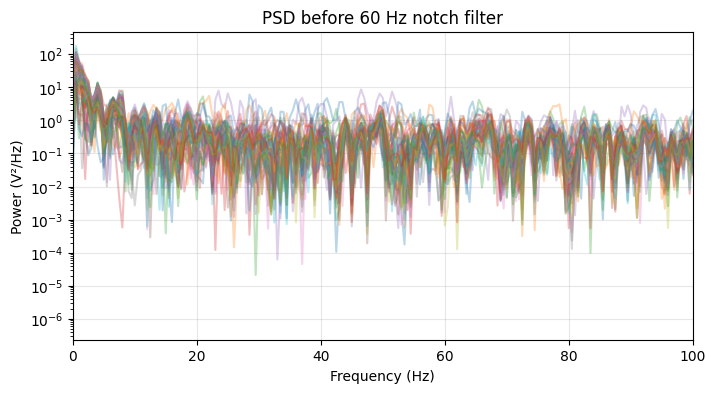

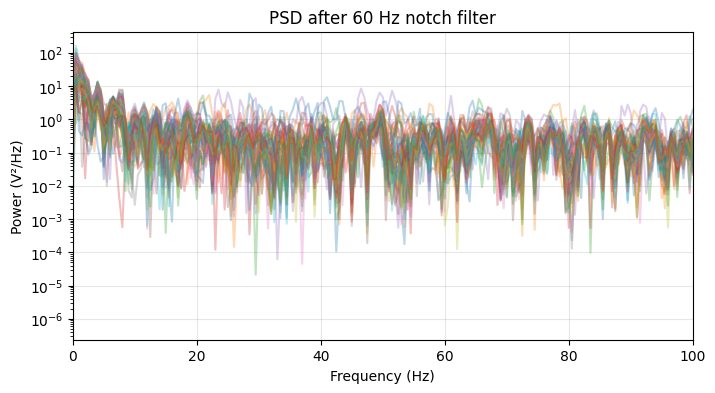

In [ ]:
# --- PSD before filtering ---
plt.figure(figsize=(8, 4))
for ch in range(data.shape[0]):
    freqs, psd = welch(data[ch, :], fs=sampling_rate, nperseg=sampling_rate*2)  # 2-second windows
    plt.semilogy(freqs, psd, alpha=0.3)  # alpha for transparency
plt.title('PSD before 60 Hz notch filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V²/Hz)')
plt.xlim(0, 100)  # match spectopo’s default range
plt.grid(True, alpha=0.3)

# --- PSD after filtering ---
plt.figure(figsize=(8, 4))
for ch in range(data_filt.shape[0]):
    freqs, psd = welch(data_filt[ch, :], fs=sampling_rate, nperseg=sampling_rate*2)
    plt.semilogy(freqs, psd, alpha=0.3)
plt.title('PSD after 60 Hz notch filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V²/Hz)')
plt.xlim(0, 100)
plt.grid(True, alpha=0.3)

plt.show()

Designed notch filter: f0 = 60 Hz, Q = 35, bandwidth ≈ 1.71 Hz


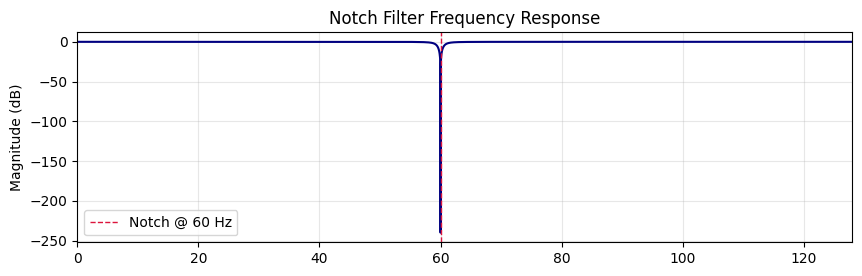

In [ ]:
bw = f0 / Q
print(f"Designed notch filter: Notch frequency = {f0} Hz, Quality factor = {Q}, bandwidth ≈ {bw:.2f} Hz")

# Frequency response
w, h = freqz(b, a, worN=4096, fs=sampling_rate)   # w in Hz because fs is provided
mag_db = 20 * np.log10(np.maximum(np.abs(h), 1e-12))  # avoid log(0)
phase_deg = np.unwrap(np.angle(h)) * 180 / np.pi

# Plot magnitude response
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(w, mag_db, color='navy', lw=1.5)
plt.axvline(f0, color='crimson', ls='--', lw=1, label=f'Notch @ {f0:.0f} Hz')
plt.title('Notch Filter Frequency Response')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, sampling_rate/2)
plt.grid(True, alpha=0.3)
plt.legend()

### Common Average Reference

In [ ]:
# Step 3: Compute average across channels at each time point
avg_ref = np.mean(data_filt, axis=0, keepdims=True)  # shape (1, n_samples)

# Step 3: Subtract the average from each channel
data_car = data_filt - avg_ref  # shape stays (n_channels, n_samples)

In [ ]:
# Step 4: Epoching around "rt"

event_latencies = np.array([e.latency for e in EEG.event])
event_types = np.array([e.type for e in EEG.event])

# Find indices where event type == 'rt'
target_idx = np.where(event_types == 'rt')[0]

# Define epoch window (e.g., -0.2s to +0.8s)
epoch_window = np.round(np.array([-0.2, 0.8]) * EEG.srate).astype(int)
epoch_len = np.diff(epoch_window)[0] + 1

# Preallocate epochs array: [n_channels, epoch_len, n_epochs]
epochs = np.full((data_car.shape[0], epoch_len, len(target_idx)), np.nan)

for i, idx_t in enumerate(target_idx):
    center = int(round(event_latencies[idx_t]))
    idx = np.arange(center + epoch_window[0], center + epoch_window[1] + 1)
    if idx[0] > 0 and idx[-1] < data_car.shape[1]:
        epochs[:, :, i] = data_car[:, idx]


### Baseline Correction

In [ ]:
# Step 5: Baseline correction
baseline_idx = np.arange(0, round(0.2 * EEG.srate))  # first 200 ms
baseline = np.mean(epochs[:, baseline_idx, :], axis=1, keepdims=True)
epochs_bc = epochs - baseline

### Improved Artifact Rejection

In [ ]:
# -------------------------
# Step 6: Improved Artifact Rejection
# -------------------------

# (a) Reject bad trials
# Compute variance of each channel within each trial → shape: (n_channels, n_trials)
trial_var = np.var(epochs_bc, axis=1)  # variance over time (axis=1)
trial_mean_var = np.mean(trial_var, axis=0)  # mean variance across channels (per trial)

# Compute rejection threshold (mean + 3*SD)
threshold = np.mean(trial_mean_var) + 3 * np.std(trial_mean_var)

# Boolean mask for rejected and accepted trials
trial_reject = trial_mean_var > threshold
good_trials = ~trial_reject

# Keep only good trials
epochs_clean = epochs_bc[:, :, good_trials]

print(f"Rejected {np.sum(trial_reject)}/{len(trial_reject)} trials")

# (b) Reject bad channels (flat or high variance across trials)
# Compute channel variance across both time and trials
chan_var = np.var(epochs_clean, axis=(1, 2))  # variance over (time, trials)

# Flag bad channels
bad_chans = (chan_var < 1e-6) | (chan_var > np.mean(chan_var) + 3 * np.std(chan_var))
good_chans = np.where(~bad_chans)[0]

# Keep only good channels
epochs_clean = epochs_clean[good_chans, :, :]

print(f"Rejected {np.sum(bad_chans)}/{len(chan_labels)} channels")

# Update channel labels
chan_labels_clean = [chan_labels[i] for i in good_chans]

In [ ]:
# -------------------------
# Step 6: Improved Artifact Rejection
# -------------------------

# (a) Reject bad trials
# Compute variance of each channel within each trial → shape: (n_channels, n_trials)
trial_var = np.var(epochs_bc, axis=1)  # variance over time (axis=1)
trial_mean_var = np.mean(trial_var, axis=0)  # mean variance across channels (per trial)

# Compute rejection threshold (mean + 3*SD)
threshold = np.mean(trial_mean_var) + 3 * np.std(trial_mean_var)

# Boolean mask for rejected and accepted trials
trial_reject = trial_mean_var > threshold
good_trials = ~trial_reject

# Keep only good trials
epochs_clean = epochs_bc[:, :, good_trials]

print(f"Rejected {np.sum(trial_reject)}/{len(trial_reject)} trials")

# (b) Reject bad channels (flat or high variance across trials)
# Compute channel variance across both time and trials
chan_var = np.var(epochs_clean, axis=(1, 2))  # variance over (time, trials)

# Flag bad channels
bad_chans = (chan_var < 1e-6) | (chan_var > np.mean(chan_var) + 3 * np.std(chan_var))
good_chans = np.where(~bad_chans)[0]

# Keep only good channels
epochs_clean = epochs_clean[good_chans, :, :]

print(f"Rejected {np.sum(bad_chans)}/{len(chan_labels)} channels")

# Update channel labels
chan_labels_clean = [chan_labels[i] for i in good_chans]

In [ ]:
# -------------------------
# Step 6: Improved Artifact Rejection
# -------------------------

# (a) Reject bad trials
# Compute variance of each channel within each trial → shape: (n_channels, n_trials)
trial_var = np.var(epochs_bc, axis=1)  # variance over time (axis=1)
trial_mean_var = np.mean(trial_var, axis=0)  # mean variance across channels (per trial)

# Compute rejection threshold (mean + 3*SD)
threshold = np.mean(trial_mean_var) + 3 * np.std(trial_mean_var)

# Boolean mask for rejected and accepted trials
trial_reject = trial_mean_var > threshold
good_trials = ~trial_reject

# Keep only good trials
epochs_clean = epochs_bc[:, :, good_trials]

print(f"Rejected {np.sum(trial_reject)}/{len(trial_reject)} trials")

# (b) Reject bad channels (flat or high variance across trials)
# Compute channel variance across both time and trials
chan_var = np.var(epochs_clean, axis=(1, 2))  # variance over (time, trials)

# Flag bad channels
bad_chans = (chan_var < 1e-6) | (chan_var > np.mean(chan_var) + 3 * np.std(chan_var))
good_chans = np.where(~bad_chans)[0]

# Keep only good channels
epochs_clean = epochs_clean[good_chans, :, :]

print(f"Rejected {np.sum(bad_chans)}/{len(chan_labels)} channels")

# Update channel labels
chan_labels_clean = [chan_labels[i] for i in good_chans]

Dot product_1: 1.0702150637227752
Dot product_2: 1.0702150637227752
Dot product_3: 1.0702150637227754


/tmp/ipython-input-3664625546.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dotproduct = float(a.T @ b)   # ensure scalar


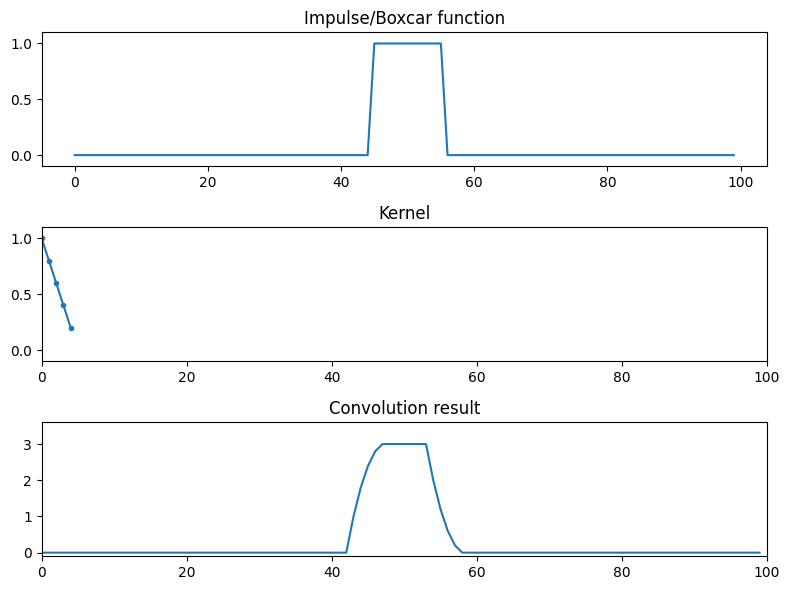

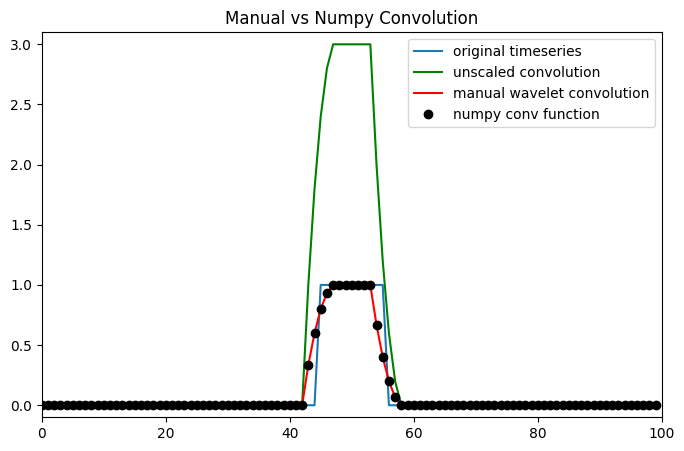

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# %% Dot products

# two vectors of random numbers
a = np.random.randn(10, 1)
b = np.random.randn(10, 1)

# initialize temporary matrix
pointwise_result = np.zeros_like(a)

for i in range(len(a)):
    pointwise_result[i] = a[i] * b[i]
dotproduct = np.sum(pointwise_result)
print("Dot product_1:", dotproduct)

# More elegant: elementwise multiply and sum
dotproduct = np.sum(a * b)
print("Dot product_2:", dotproduct)
# Most elegant: vector dot product
dotproduct = float(a.T @ b)   # ensure scalar

print("Dot product_3:", dotproduct)

# %% Figure 10.2

# impulse function (all zeros; 1 in the middle)
impfun = np.zeros(100)
impfun[50] = 1

# wider boxcar instead of strict impulse
impfun[45:56] = 1

kernel = np.array([1, 0.8, 0.6, 0.4, 0.2])

# numpy convolution function
matlab_conv_result = np.convolve(impfun, kernel, mode="same")

plt.figure(figsize=(8, 6))

# plot the signal (impulse or boxcar)
plt.subplot(311)
plt.plot(impfun)
plt.ylim([-.1, 1.1])
plt.title("Impulse/Boxcar function")

# plot the kernel
plt.subplot(312)
plt.plot(kernel, '.-')
plt.xlim([0, 100])
plt.ylim([-.1, 1.1])
plt.title("Kernel")

# plot the result of convolution
plt.subplot(313)
plt.plot(matlab_conv_result)
plt.xlim([0, 100])
plt.ylim([-.1, 3.6])
plt.title("Convolution result")

plt.tight_layout()
plt.show()

# %% Figure 10.4

# data that we'll use for convolution (must be zero-padded).
dat4conv = np.concatenate([
    np.zeros(len(kernel) - 1),
    impfun,
    np.zeros(len(kernel) - 1)
])

# used for cutting the result of convolution
half_of_kernel_size = int(np.ceil((len(kernel) - 1) / 2))

# initialize convolution output
convolution_result = np.zeros(len(impfun) + len(kernel) - 1)

# run convolution (note kernel is flipped backwards)
for ti in range(len(convolution_result) - half_of_kernel_size):
    convolution_result[ti] = np.sum(dat4conv[ti:ti+len(kernel)] * kernel[::-1])

# cut off edges
convolution_result = convolution_result[half_of_kernel_size : -half_of_kernel_size]

plt.figure(figsize=(8, 5))
plt.plot(impfun, label="original timeseries")
plt.plot(convolution_result, 'g', label="unscaled convolution")
plt.plot(convolution_result / np.sum(kernel), 'r', label="manual wavelet convolution")
plt.plot(matlab_conv_result / np.sum(kernel), 'ko', label="numpy conv function")
plt.xlim([0, 100])
plt.ylim([-.1, 3.1])
plt.legend()
plt.title("Manual vs Numpy Convolution")
plt.show()


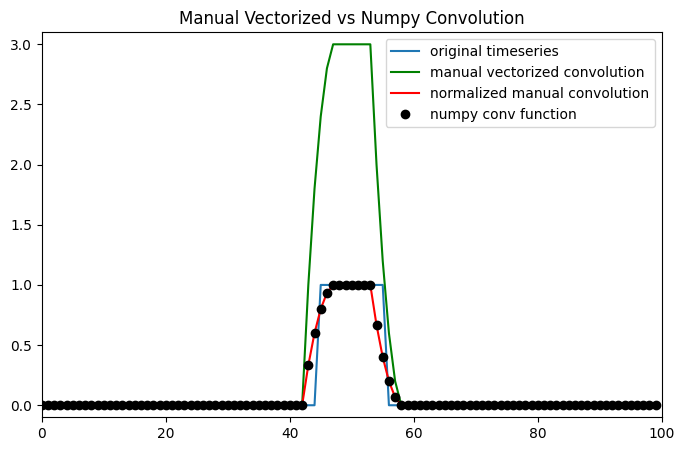

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

# impulse/boxcar function
impfun = np.zeros(100)
impfun[45:56] = 1

kernel = np.array([1, 0.8, 0.6, 0.4, 0.2])

# zero-padding for convolution
dat4conv = np.concatenate([
    np.zeros(len(kernel) - 1),
    impfun,
    np.zeros(len(kernel) - 1)
])

# flip kernel
kernel_flipped = kernel[::-1]

# create sliding windows of size = kernel
windows = sliding_window_view(dat4conv, len(kernel))

# vectorized convolution: matrix multiply
convolution_result = windows @ kernel_flipped

# cut off edges
half_of_kernel_size = int(np.ceil((len(kernel) - 1) / 2))
convolution_result = convolution_result[half_of_kernel_size : -half_of_kernel_size]

# compare with numpy's built-in convolution
matlab_conv_result = np.convolve(impfun, kernel, mode="same")

# plot
plt.figure(figsize=(8, 5))
plt.plot(impfun, label="original timeseries")
plt.plot(convolution_result, 'g', label="manual vectorized convolution")
plt.plot(convolution_result / np.sum(kernel), 'r', label="normalized manual convolution")
plt.plot(matlab_conv_result / np.sum(kernel), 'ko', label="numpy conv function")
plt.xlim([0, 100])
plt.ylim([-.1, 3.1])
plt.legend()
plt.title("Manual Vectorized vs Numpy Convolution")
plt.show()


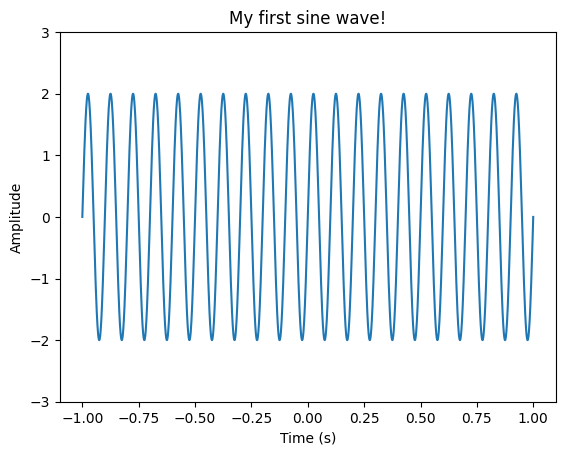

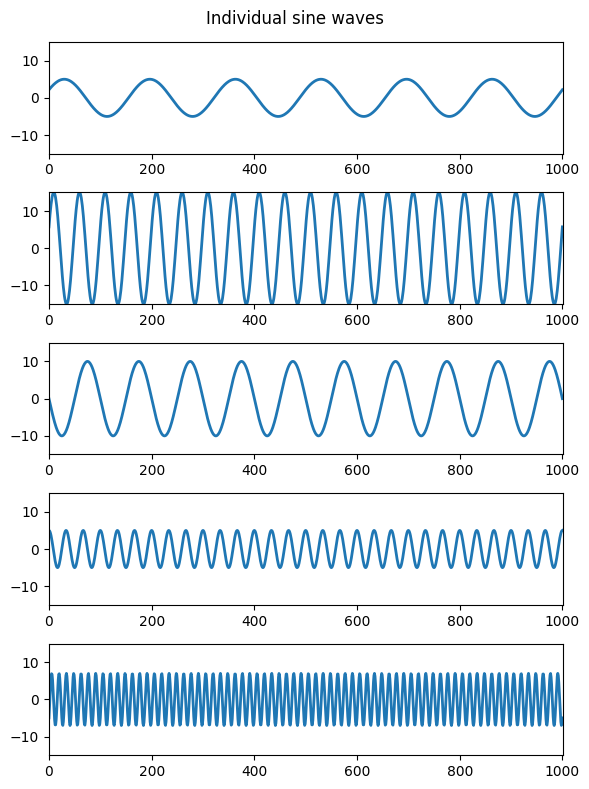

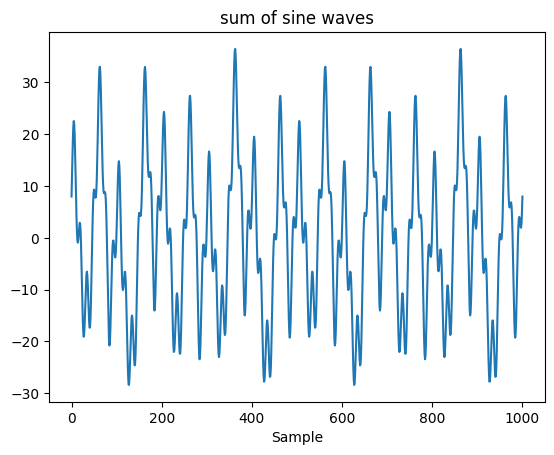

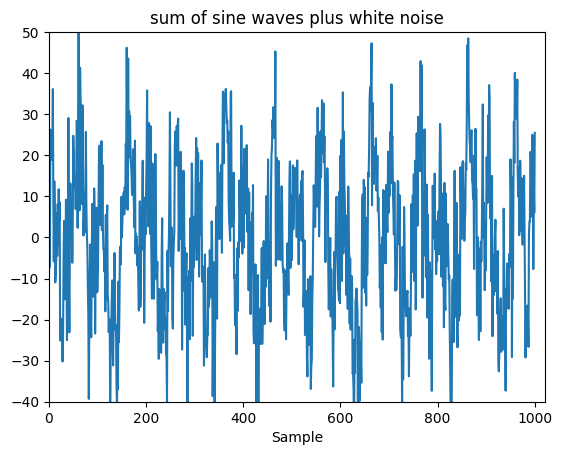

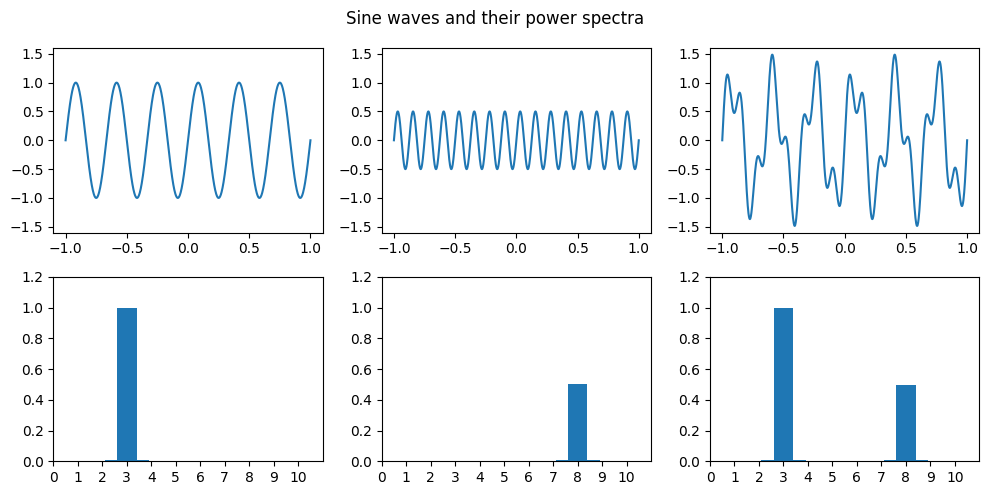

AttributeError: 'numpy.ndarray' object has no attribute 'time'

In [ ]:
"""
Chapter 11 — Python translation of Mike X Cohen's MATLAB demo
Requirements:
    numpy, scipy, matplotlib
Optional (if you have sampleEEGdata.mat):
    scipy.io.loadmat will try to load 'sampleEEGdata.mat'
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack, signal
from scipy.io import loadmat
import os
import time

# --------------------------
# Figure 11.1 — single sine wave
# --------------------------
srate = 1000  # Hz
time = np.arange(-1.0, 1.0 + 1.0 / srate, 1.0 / srate)
freq = 10.0  # Hz
amp = 2.0
sine_wave = amp * np.sin(2 * np.pi * freq * time)

plt.figure()
plt.plot(time, sine_wave)
plt.ylim([-3, 3])
plt.title('My first sine wave!')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# --------------------------
# Figure 11.2 — sum of several sines
# --------------------------
srate = 500
frex = np.array([3, 10, 5, 15, 35])
amplit = np.array([5, 15, 10, 5, 7])
phases = np.array([np.pi / 7, np.pi / 8, np.pi, np.pi / 2, -np.pi / 4])
time = np.arange(-1.0, 1.0 + 1.0 / srate, 1.0 / srate)

sine_waves = np.zeros((len(frex), len(time)))
for fi in range(len(frex)):
    sine_waves[fi, :] = amplit[fi] * np.sin(2 * np.pi * frex[fi] * time + phases[fi])

plt.figure(figsize=(6, 8))
for fi in range(len(frex)):
    ax = plt.subplot(len(frex), 1, fi + 1)
    ax.plot(sine_waves[fi, :], linewidth=2)
    ax.set_xlim([0, len(time)])
    ax.set_ylim([-np.max(amplit), np.max(amplit)])
plt.suptitle('Individual sine waves')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(np.sum(sine_waves, axis=0))
plt.title('sum of sine waves')
plt.xlabel('Sample')
plt.show()

# --------------------------
# Figure 11.3 — sum + noise
# --------------------------
plt.figure()
plt.plot(np.sum(sine_waves + 5 * np.random.randn(*sine_waves.shape), axis=0))
plt.axis([0, len(time) + 20, -40, 50])
plt.title('sum of sine waves plus white noise')
plt.xlabel('Sample')
plt.show()

# --------------------------
# Figure 11.4 — composite, spectrum
# --------------------------
time = np.arange(-1.0, 1.0 + 1.0 / srate, 1.0 / srate)
s1 = np.sin(2 * np.pi * 3 * time)
s2 = 0.5 * np.sin(2 * np.pi * 8 * time)
s3 = s1 + s2

plt.figure(figsize=(10, 5))
for i, s in enumerate([s1, s2, s3], start=1):
    ax = plt.subplot(2, 3, i)
    ax.plot(time, s)
    ax.set_ylim([-1.6, 1.6])
    ax.set_yticks(np.arange(-1.5, 1.6, 0.5))

    # power
    ax2 = plt.subplot(2, 3, i + 3)
    f = np.fft.fft(s) / len(time)
    hz = np.linspace(0, srate / 2.0, int(np.floor(len(time) / 2)) + 1)
    power = np.abs(f[: len(hz)] * 2)
    ax2.bar(hz, power)
    ax2.set_xlim([0, 11])
    ax2.set_xticks(np.arange(0, 11, 1))
    ax2.set_ylim([0, 1.2])

plt.suptitle('Sine waves and their power spectra')
plt.tight_layout()
plt.show()

# --------------------------
# Figure 11.5 — DFT via dot products vs FFT (demo with smaller N)
# --------------------------
# MATLAB used N=1_000_000 for demo but that is extremely slow to do naive DFT.
# We'll use a smaller N for naive DFT demonstration and compare to FFT.
N_demo = 4096  # use power of two for fft efficiency; change as needed
data = np.random.randn(N_demo)
srate = 200
nyquist = srate / 2.0

# Frequencies for plotting
frequencies = np.linspace(0, nyquist, N_demo // 2 + 1)
time_unit = np.arange(0, N_demo) / N_demo

# Naive (slow) DFT demonstration (only for small N_demo)
start = time.time()
fourier = np.zeros(N_demo, dtype=complex)
# compute DFT by dot-product between complex exponentials and data
for fi in range(N_demo):
    sine_wave = np.exp(-1j * 2 * np.pi * fi * time_unit)
    fourier[fi] = np.sum(sine_wave * data)
fourier = fourier / N_demo
t_naive = time.time() - start

# FFT
start = time.time()
fftdat = np.fft.fft(data)
t_fft = time.time() - start

print(f"Naive DFT time (N={N_demo}): {t_naive:.3f}s, FFT time: {t_fft:.6f}s")

# Plot time domain
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.plot(data, '-o', markersize=2)
plt.xlim([0, N_demo + 1])
plt.title('Time domain representation of the data')

# 3D-like representation (matplotlib can't easily plot 3d angle-power nicely in 2D)
ax = plt.subplot(222, projection='3d')
ax.plot(frequencies, np.angle(fourier[: N_demo // 2 + 1]), np.abs(fourier[: N_demo // 2 + 1]) ** 2, '-o', linewidth=1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase')
ax.set_zlabel('power')
ax.view_init(elev=20, azim=20)
ax.set_title('3-D representation of the Fourier transform')

# Power spectrum
plt.subplot(223)
plt.bar(frequencies, np.abs(fourier[: N_demo // 2 + 1]) ** 2)
plt.xlim([-5, 105])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power spectrum derived from discrete Fourier transform')

# Phase spectrum
plt.subplot(224)
plt.bar(frequencies, np.angle(fourier[: N_demo // 2 + 1]))
plt.xlim([-5, 105])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase angle')
plt.yticks(np.arange(-np.pi, np.pi + 1, np.pi / 2))
plt.title('Phase spectrum derived from discrete Fourier transform')

plt.tight_layout()
plt.show()

# --------------------------
# Figure 11.6 — reconstruct via inverse DFT sum (demonstration)
# --------------------------
reconstructed_data = np.zeros_like(data, dtype=float)
for fi in range(N_demo):
    sine_wave = fourier[fi] * np.exp(1j * 2 * np.pi * fi * time_unit)
    reconstructed_data = reconstructed_data + np.real(sine_wave)

plt.figure()
plt.plot(data, '-o', markersize=2)
plt.plot(reconstructed_data, 'r-*', markersize=2)
plt.legend(['original data', 'inverse Fourier transform data'])
plt.title('Reconstruction from DFT coefficients')
plt.show()

# --------------------------
# Figure 11.7 — compare time-domain Fourier and FFT
# --------------------------
fft_data_norm = np.fft.fft(data) / N_demo

plt.figure(figsize=(10, 3.5))
plt.subplot(131)
plt.plot(frequencies, np.abs(fourier[: N_demo // 2 + 1]) ** 2, '*-')
plt.plot(frequencies, np.abs(fft_data_norm[: N_demo // 2 + 1]) ** 2, 'ro-', markersize=4)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power: time-domain DFT vs FFT')
plt.axis('square')
plt.legend(['time-domain DFT', 'FFT'])

plt.subplot(132)
plt.plot(frequencies, np.angle(fourier[: N_demo // 2 + 1]), '*-')
plt.plot(frequencies, np.angle(fft_data_norm[: N_demo // 2 + 1]), 'ro-', markersize=4)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase')
plt.title('Phase: time-domain DFT vs FFT')
plt.yticks(np.arange(-np.pi, np.pi + 1, np.pi / 2))
plt.axis('square')

plt.subplot(133)
plt.plot(reconstructed_data, '*-')
plt.plot(np.real(np.fft.ifft(np.fft.fft(data))), 'ro-', markersize=4)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Manual inverse DFT vs ifft')
plt.axis('square')

plt.tight_layout()
plt.show()

# --------------------------
# Figure 11.9 — stationary vs non-stationary combination
# --------------------------
frex = np.array([3, 10, 5, 7])
amplit = np.array([5, 15, 10, 5])
phases = np.array([np.pi / 7, np.pi / 8, np.pi, np.pi / 2])

srate = 500
time = np.arange(-1.0, 1.0 + 1.0 / srate, 1.0 / srate)

stationary = np.zeros(1 * len(time) * len(frex))
nonstationary = np.zeros_like(stationary)

for fi in range(len(frex)):
    temp_sine_wave = amplit[fi] * np.sin(2 * np.pi * frex[fi] * time + phases[fi])
    # add repeated to stationary
    stationary += np.tile(temp_sine_wave, len(frex))
    # amplitude change over time (example)
    temp_sine_wave_mod = temp_sine_wave * (time + 1.0)
    start_idx = fi * len(time)
    stop_idx = start_idx + len(time)
    nonstationary[start_idx:stop_idx] = temp_sine_wave_mod

plt.figure()
plt.subplot(221)
plt.plot(stationary, 'r')
plt.xlim([1, len(stationary)])
plt.title('stationary signal')

plt.subplot(222)
plt.plot(nonstationary)
plt.xlim([1, len(nonstationary)])
plt.title('non-stationary signal')

# FFT comparisons
frequencies = np.linspace(0, srate / 2.0, int(len(nonstationary) / 2) + 1)
fft_nonstationary = np.fft.fft(nonstationary) / len(nonstationary)
fft_stationary = np.fft.fft(stationary) / len(stationary)

plt.subplot(212)
plt.plot(frequencies, np.abs(fft_stationary[: len(frequencies)]) * 2.0, 'r', label='Power stationary')
plt.plot(frequencies, np.abs(fft_nonstationary[: len(frequencies)]) * 2.0, label='Power non-stationary')
plt.xlim([0, np.max(frex) * 2])
plt.legend()
plt.title('Power: stationary vs non-stationary')
plt.tight_layout()
plt.show()


In [ ]:
# --------------------------
# Figure 11.10+11.12 — EEG convolution examples
# --------------------------
# Try to load sampleEEGdata.mat if present; otherwise create synthetic EEG
eeg_file = "sampleEEGdata.mat"
if os.path.exists(eeg_file):
    print("Loading sampleEEGdata.mat ...")
    mat = loadmat(eeg_file)
    # Attempt to extract common structure names from MATLAB file
    # The MATLAB example referenced EEG.data (channels x time x trials), EEG.srate, EEG.times
    if 'EEG' in mat:
        EEG = mat['EEG']
        # This may need adaptation depending on the mat-file structure
        try:
            eeg_data = np.squeeze(EEG['data'][0, 0])[46, :, 0]  # index 47 in MATLAB -> 46 in Python
            eeg_srate = float(np.squeeze(EEG['srate'][0, 0]))
            eeg_times = np.squeeze(EEG['times'][0, 0])
        except Exception as e:
            print("Could not parse EEG structure automatically:", e)
            # fallback to synthetic
            eeg_data = np.random.randn(1000)
            eeg_srate = 250.0
            eeg_times = np.arange(len(eeg_data)) / eeg_srate
    else:
        print("No 'EEG' variable in MAT file; using synthetic EEG instead.")
        eeg_data = np.random.randn(1000)
        eeg_srate = 250.0
        eeg_times = np.arange(len(eeg_data)) / eeg_srate
else:
    print("sampleEEGdata.mat not found — using synthetic EEG data.")
    eeg_srate = 250.0
    # create synthetic EEG-like signal (sum of sinusoids + noise)
    tlen = 2.0  # seconds
    eeg_times = np.arange(0, tlen, 1.0 / eeg_srate)
    eeg_data = 10 * np.sin(2 * np.pi * 10 * eeg_times) + 3 * np.sin(2 * np.pi * 20 * eeg_times) + 2 * np.random.randn(len(eeg_times))

# Create Gaussian kernel
time_gauss = np.arange(-1.0, 1.0 + 1.0 / eeg_srate, 1.0 / eeg_srate)
s = 5.0 / (2 * np.pi * 30)
gaussian = np.exp((-time_gauss ** 2) / (2 * s ** 2)) / 30.0

plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.plot(eeg_data)
plt.title('EEG data (channel example)')
plt.subplot(212)
plt.plot(time_gauss, gaussian)
plt.title('Gaussian kernel')
plt.tight_layout()
plt.show()

# Convolution (same mode)
conv_result = signal.convolve(eeg_data, gaussian, mode='same')

plt.figure()
plt.subplot(311)
plt.plot(conv_result)
plt.title('Result of convolution (same)')
plt.subplot(312)
plt.plot(np.abs(np.fft.fft(conv_result)))
plt.title('Abs FFT of convolved signal')
plt.subplot(313)
plt.plot(np.abs(np.fft.fft(eeg_data)))
plt.title('Abs FFT of original EEG data')
plt.tight_layout()
plt.show()

# More analysis like Figure 11.11: Sine + gaussian with variable fg
srate = 1000
time_short = np.arange(-0.5, 0.5, 1.0 / srate)
f = 20
fg = [15, 5]
s = np.sin(2 * np.pi * f * time_short)

for fg_i in fg:
    # gaussian width scaled similarly to MATLAB code
    g = np.exp((-time_short ** 2) / (2 * (4 / (2 * np.pi * fg_i)) ** 2)) / fg_i

    plt.figure(figsize=(8, 8))
    plt.subplot(411)
    plt.plot(time_short, s)
    plt.title('Sine wave (signal)')
    plt.ylim([-1.1, 1.1])

    plt.subplot(412)
    plt.plot(time_short, g)
    plt.title('Gaussian (kernel)')

    plt.subplot(413)
    conv_sg = signal.convolve(s, g, mode='same')
    plt.plot(time_short, conv_sg)
    plt.ylim([-1.1, 1.1])
    plt.title('result of convolution')

    # compute normalized spectra for plotting
    fft_s = np.abs(np.fft.fft(s))
    fft_s = fft_s[: (len(fft_s) // 2) + 1]
    fft_s = fft_s / np.max(fft_s)

    fft_g = np.abs(np.fft.fft(g))
    fft_g = fft_g[: (len(fft_g) // 2) + 1]
    fft_g = fft_g / np.max(fft_g)

    freqs = np.linspace(0, srate / 2.0, len(fft_s))

    plt.subplot(427)
    plt.bar(np.arange(0, len(fft_s)), fft_s, color='r', alpha=0.6)
    plt.plot(np.arange(0, len(fft_g)), fft_g, color='k')
    plt.xlim([0, 40])
    plt.ylim([0, 1.05])
    plt.title('individual power spectra')

    plt.subplot(428)
    plt.bar(np.arange(0, len(fft_g)), fft_g * fft_s)
    plt.xlim([0, 40])
    plt.ylim([0, .035])
    plt.title('multiplied power spectra')

    plt.tight_layout()
    plt.show()

# Figure 11.12 like combined EEG/gaussian/fft visualization
time = time_gauss
s = 5.0 / (2 * np.pi * 30)
gaussian = np.exp((-time ** 2) / (2 * s ** 2)) / 30.0

nfft = len(eeg_data)
fft_s = np.abs(np.fft.fft(eeg_data, nfft))[: nfft // 2 + 1]
f = np.linspace(0, eeg_srate / 2.0, nfft // 2 + 1)
fft_s_norm = fft_s / np.max(fft_s)

fft_g = np.abs(np.fft.fft(gaussian, nfft))[: nfft // 2 + 1]
fft_g_norm = fft_g / np.max(fft_g)

plt.figure(figsize=(8, 6))
plt.subplot(411)
plt.plot(eeg_times if 'eeg_times' in locals() else np.arange(len(eeg_data)), eeg_data)
plt.title('EEG timeseries')

plt.subplot(412)
plt.plot(time, gaussian)
plt.title('Gaussian')

plt.subplot(413)
plt.plot(eeg_times if 'eeg_times' in locals() else np.arange(len(eeg_data)), eeg_data, 'r')
plt.plot(eeg_times if 'eeg_times' in locals() else np.arange(len(eeg_data)), signal.convolve(eeg_data, gaussian, mode='same'))
plt.title('original and convolved EEG')

plt.subplot(427)
plt.plot(f, fft_s_norm, 'r')
plt.plot(f, fft_g_norm)
plt.xlim([0, 60])
plt.title('normalized spectra of EEG and gaussian')

plt.subplot(428)
plt.plot(f, fft_s * fft_g)
plt.xlim([0, 60])
plt.title('multiplied spectra')
plt.tight_layout()
plt.show()

print("Done. Note: If you have the original 'sampleEEGdata.mat' saved, place it in this directory to use real EEG.")


Loaded EEG from /content/drive/MyDrive/Neuroinfo_Assignment/sampleEEGdata.mat: data shape (64, 640, 99), srate 256.0


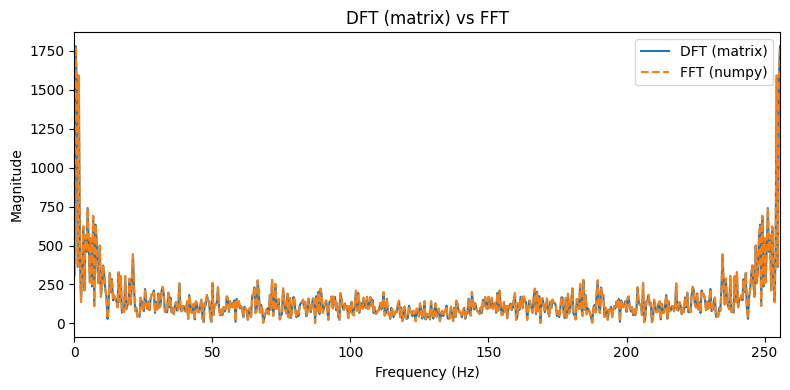

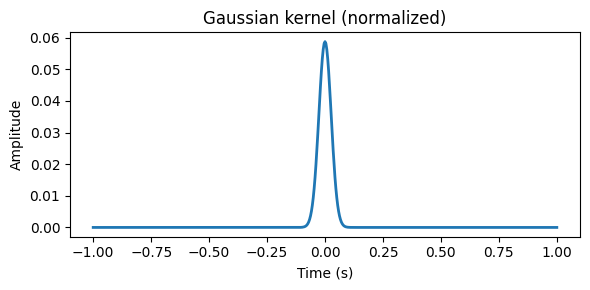

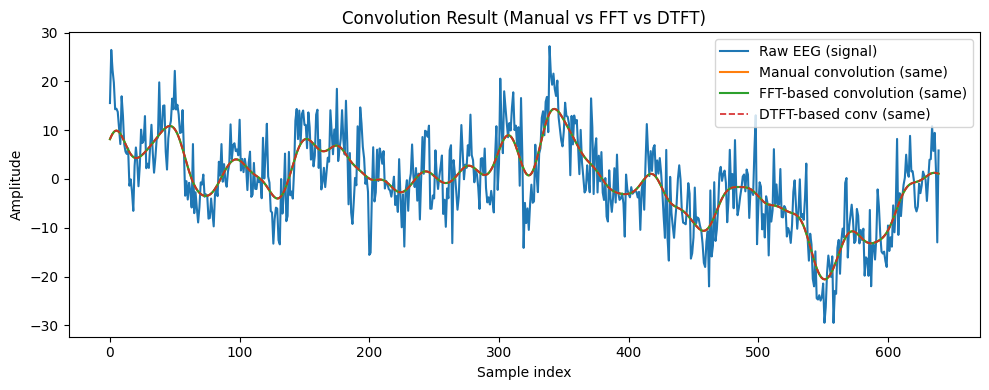

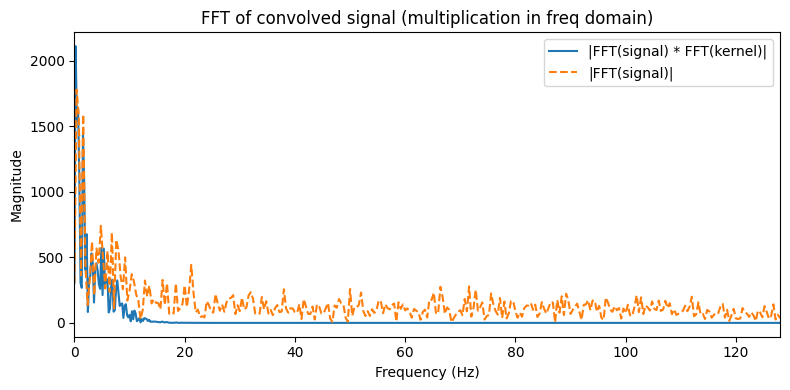

Done. Note: Gaussian acts as a low-pass filter (suppressing high frequencies).
To design a high-pass kernel, subtract a low-pass kernel from a delta (impulse) or create a derivative-like kernel.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
import os

# ---------------------------
# Helper: load EEG from MAT
# ---------------------------
def load_sample_eeg(matfile="/content/drive/MyDrive/Neuroinfo_Assignment/sampleEEGdata.mat"):
    """
    Try to load MATLAB sampleEEGdata.mat which contains an EEG struct with fields:
      EEG.data (channels x time x trials), EEG.srate, EEG.times (optional)
    If loading/parsing fails, return synthetic data and a default srate.
    """
    if not os.path.exists(matfile):
        print(f"MAT file '{matfile}' not found — using synthetic EEG.")
        # synthetic EEG: sum of sinusoids + noise
        eeg_srate = 250.0
        tlen = 2.0  # seconds
        eeg_times = np.arange(0, tlen, 1.0 / eeg_srate)
        eeg_data = 10*np.sin(2*np.pi*10*eeg_times) + 3*np.sin(2*np.pi*20*eeg_times) + 2*np.random.randn(len(eeg_times))
        # reshape to channels x time x trials -> make 1 channel, 1 trial
        data = eeg_data[np.newaxis, :, np.newaxis]
        return {'data': data, 'srate': eeg_srate, 'times': eeg_times}

    mat = loadmat(matfile, squeeze_me=True, struct_as_record=False)
    # Try to find EEG variable
    if 'EEG' in mat:
        EEG = mat['EEG']
        # Structure might vary; try common forms:
        try:
            data = np.asarray(EEG.data)  # often shape channels x time x trials
            srate = float(EEG.srate)
            times = np.asarray(EEG.times) if hasattr(EEG, 'times') else np.arange(data.shape[1]) / srate
            print(f"Loaded EEG from {matfile}: data shape {data.shape}, srate {srate}")
            return {'data': data, 'srate': srate, 'times': times}
        except Exception as e:
            print("Could not parse EEG struct automatically:", e)
    # fallback
    print("No usable EEG variable found in MAT file — using synthetic EEG.")
    eeg_srate = 250.0
    tlen = 2.0
    eeg_times = np.arange(0, tlen, 1.0 / eeg_srate)
    eeg_data = 10*np.sin(2*np.pi*10*eeg_times) + 3*np.sin(2*np.pi*20*eeg_times) + 2*np.random.randn(len(eeg_times))
    data = eeg_data[np.newaxis, :, np.newaxis]
    return {'data': data, 'srate': eeg_srate, 'times': eeg_times}

# ---------------------------
# Load EEG (or synthetic)
# ---------------------------
EEG = load_sample_eeg("/content/drive/MyDrive/Neuroinfo_Assignment/sampleEEGdata.mat")
data = EEG['data']        # channels x time x trials
srate = EEG['srate']
times = EEG['times']

# Extract signal: channel 10, trial 5 in MATLAB => indices 9 and 4 in Python
chan_idx = 9
trial_idx = 4
n_channels, n_timepoints, n_trials = data.shape
if chan_idx < n_channels and trial_idx < n_trials:
    signal_raw = np.asarray(data[chan_idx, :, trial_idx])
else:
    # fallback to first channel/trial
    print("Requested channel/trial not available, using first channel/trial.")
    signal_raw = np.asarray(data[0, :, 0])

t = np.arange(len(signal_raw)) / srate

# ---------------------------
# DFT (matrix form) vs FFT
# ---------------------------
N = len(signal_raw)
n = np.arange(N)
k = n.reshape((N, 1))  # column vector
W = np.exp(-1j * 2.0 * np.pi / N * (k @ n.reshape((1, N))))  # shape (N,N)

# Manual DFT (matrix multiply)
X_manual = W.dot(signal_raw)            # shape (N,)

# FFT (numpy)
X_fft = np.fft.fft(signal_raw)          # shape (N,)

frequencies = np.arange(N) * (srate / N)

# Plot magnitude comparison
plt.figure(figsize=(8, 4))
plt.plot(frequencies, np.abs(X_manual), label='DFT (matrix)')
plt.plot(frequencies, np.abs(X_fft), '--', label='FFT (numpy)')
plt.xlim([0, frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.title('DFT (matrix) vs FFT')
plt.tight_layout()
plt.show()

# ---------------------------
# Gaussian kernel
# ---------------------------
time_kernel = np.arange(-1.0, 1.0 + 1.0/srate, 1.0/srate)  # similar to -1:1/EEG.srate:1
s = 5.0 / (2.0 * np.pi * 30.0)
kernel = np.exp(-(time_kernel**2) / (2.0 * s**2)) / 30.0
kernel = kernel / np.sum(kernel)  # normalize

plt.figure(figsize=(6, 3))
plt.plot(time_kernel, kernel, '-', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Gaussian kernel (normalized)')
plt.tight_layout()
plt.show()

# ---------------------------
# Manual convolution (nested loops)
# ---------------------------
M = len(kernel)
conv_length = N + M - 1
conv_result = np.zeros(conv_length, dtype=float)

# MATLAB-style manual convolution:
# for n=1:conv_length
#   for k=1:length(kernel)
#       if (n-k+1 > 0) && (n-k+1 <= length(signal))
#           conv_result(n) = conv_result(n) + kernel(k) * signal(n-k+1)
#       end
#   end
# end
for nn in range(conv_length):                 # nn corresponds to MATLAB n-1
    acc = 0.0
    for kk in range(M):                       # kk corresponds k-1
        idx = nn - kk                         # corresponds to n-k
        if 0 <= idx < N:
            acc += kernel[kk] * signal_raw[idx]
    conv_result[nn] = acc

# ---------------------------
# DTFT-based convolution (evaluate frequency response then inverse)
# ---------------------------
N_dtft = conv_length
omega = 2.0 * np.pi * np.arange(N_dtft) / N_dtft

# Compute DTFT samples for signal and kernel
X_dtft = np.zeros(N_dtft, dtype=complex)
K_dtft = np.zeros(N_dtft, dtype=complex)

n_sig = np.arange(N)
n_ker = np.arange(M)

for wi in range(N_dtft):
    w = omega[wi]
    X_dtft[wi] = np.sum(signal_raw * np.exp(-1j * w * n_sig))
    K_dtft[wi] = np.sum(kernel * np.exp(-1j * w * n_ker))

Y_dtft = X_dtft * K_dtft

# Inverse DTFT-like synthesis (discrete inverse at those sampled omegas)
conv_dtft = np.zeros(N_dtft, dtype=complex)
for nn in range(N_dtft):
    conv_dtft[nn] = np.sum(Y_dtft * np.exp(1j * omega * nn)) / N_dtft
conv_dtft = np.real(conv_dtft)

# ---------------------------
# FFT-based convolution
# ---------------------------
N_fft = conv_length
fft_sig = np.fft.fft(np.concatenate([signal_raw, np.zeros(N_fft - N)]), n=N_fft)
fft_kernel = np.fft.fft(np.concatenate([kernel, np.zeros(N_fft - M)]), n=N_fft)
conv_fft = np.fft.ifft(fft_sig * fft_kernel)

# ---------------------------
# Trim to 'same' (MATLAB conv(...,'same'))
# ---------------------------
pad = int(np.floor(M / 2.0))
start = pad
end = start + N   # should result in length N
conv_result_same = conv_result[start:start + N]
conv_fft_same = np.real(conv_fft[start:start + N])
conv_dtft_same = np.real(conv_dtft[start:start + N])

# ---------------------------
# Plot time-domain comparison
# ---------------------------
plt.figure(figsize=(10, 4))
plt.plot(signal_raw, '-', label='Raw EEG (signal)')
plt.plot(conv_result_same, '-', label='Manual convolution (same)')
plt.plot(conv_fft_same, '-', linewidth=1.5, label='FFT-based convolution (same)')
plt.plot(conv_dtft_same, '--', linewidth=1.2, label='DTFT-based conv (same)')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.title('Convolution Result (Manual vs FFT vs DTFT)')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# Frequency-domain: convolution property
# ---------------------------
frequencies_conv = np.arange(N_fft) * (srate / N_fft)

plt.figure(figsize=(8, 4))
plt.plot(frequencies_conv, np.abs(fft_sig * fft_kernel), label='|FFT(signal) * FFT(kernel)|')
# For comparison: original signal FFT (magnitude)
freqs_sig = np.arange(N) * (srate / N)
plt.plot(freqs_sig, np.abs(X_fft), '--', label='|FFT(signal)|')
plt.xlim([0, frequencies_conv[len(frequencies_conv)//2]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of convolved signal (multiplication in freq domain)')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# Optional: Suggestion for high-pass filter kernel
# ---------------------------
print("Done. Note: Gaussian acts as a low-pass filter (suppressing high frequencies).")
print("To design a high-pass kernel, subtract a low-pass kernel from a delta (impulse) or create a derivative-like kernel.")


In [ ]:
print(os.path.exists("/content/drive/MyDrive/Neuroinfo_Assignment/sampleEEGdata.mat"))

True


##16/09/2025

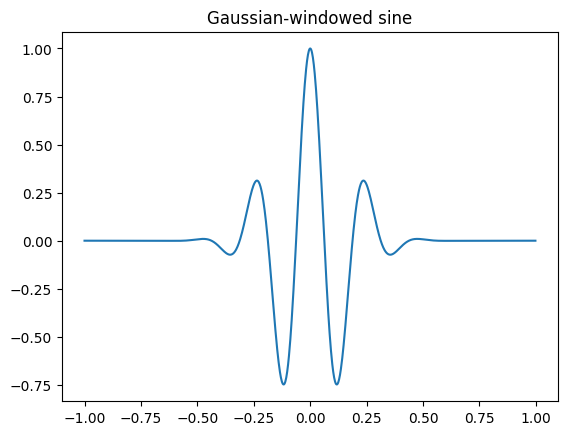

Dot product: 0.0669150645411473


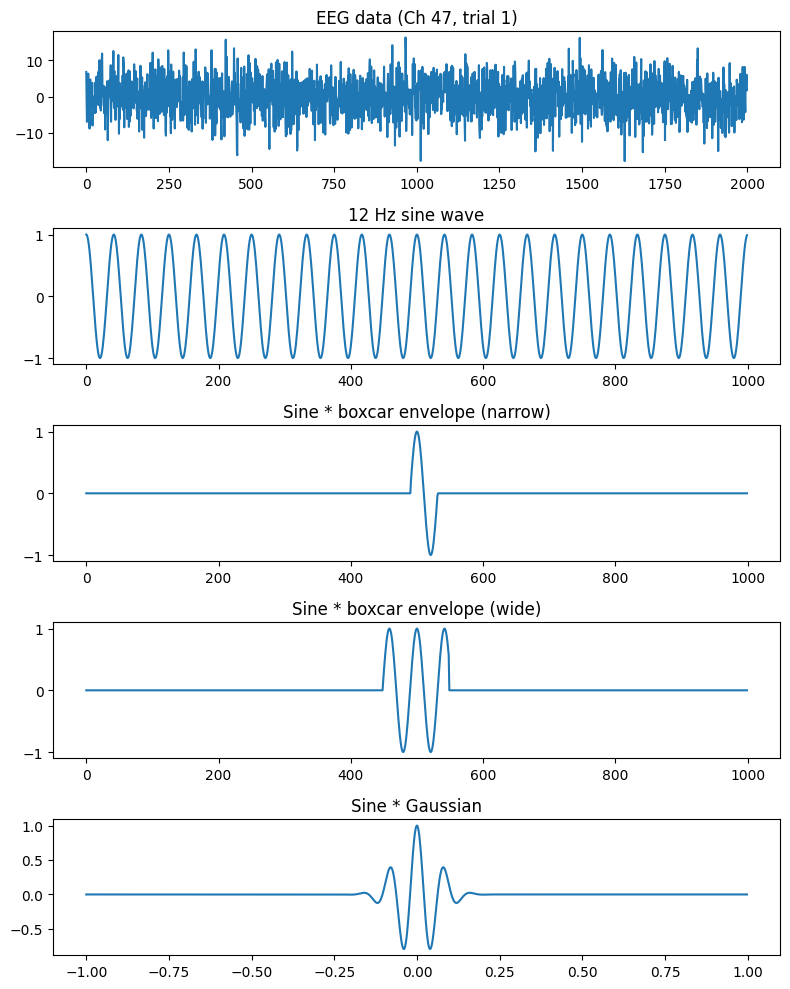

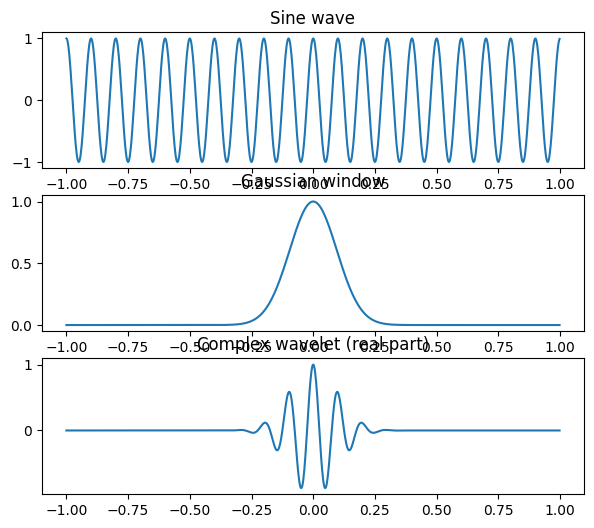

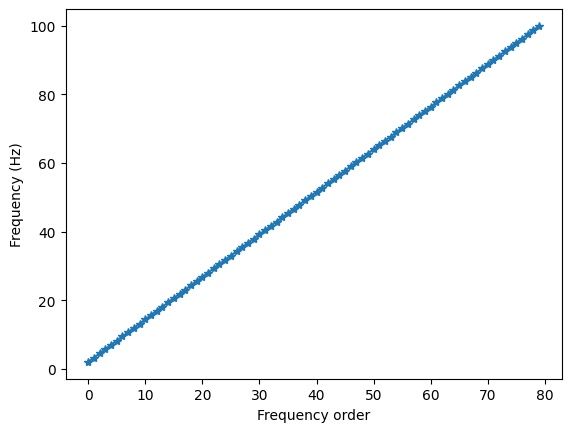

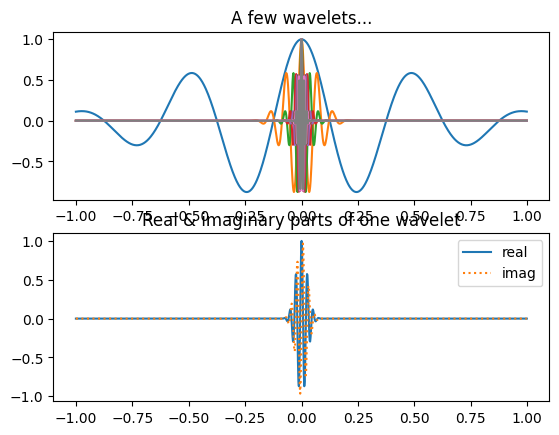

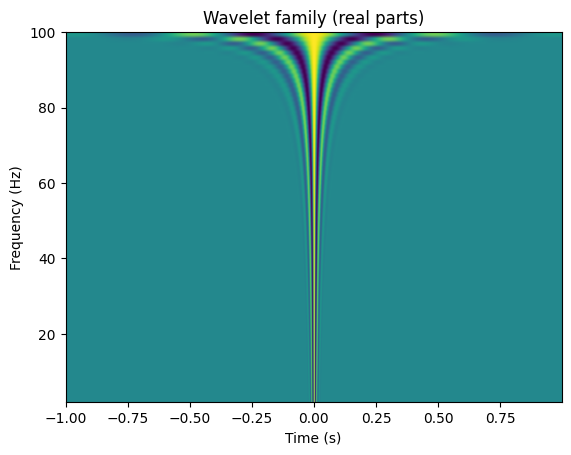

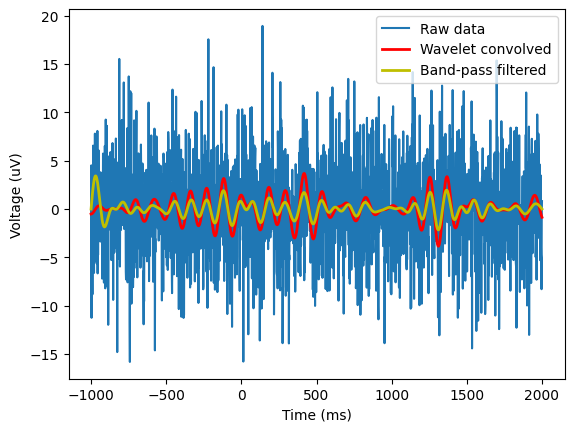

In [ ]:
# Analyzing Neural Time Series Data
# Chapter 12 - Python Translation
# Based on Mike X Cohen's MATLAB examples

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firls, filtfilt
from scipy.fftpack import fft, ifft

# ---------------------------------------------------------
# Load EEG sample data (here we simulate - replace with actual dataset)
# In MATLAB: load sampleEEGdata
# We'll simulate EEG structure: EEG.data [channels x samples x trials]
# and EEG.srate, EEG.times, EEG.pnts, EEG.chanlocs

class EEG:
    pass

EEG = EEG()
EEG.srate = 500
EEG.pnts = 2000
EEG.times = np.linspace(-1000, 2000, EEG.pnts)
EEG.data = np.random.randn(64, EEG.pnts, 50) * 5  # fake EEG data
EEG.chanlocs = [{'labels': f'Ch{i}'} for i in range(64)]

# ---------------------------------------------------------
# Figure 12.1
time = np.arange(-1, 1, 1/EEG.srate)
f = 4  # Hz
sine_wave = np.cos(2*np.pi*f*time)

s = 4/(2*np.pi*f)
gaussian_win = np.exp(-time**2/(2*s**2))

plt.figure()
plt.plot(time, sine_wave * gaussian_win)
plt.title("Gaussian-windowed sine")
plt.show()

print("Dot product:", np.dot(sine_wave, gaussian_win))

# ---------------------------------------------------------
# Figure 12.2
plt.figure(figsize=(8,10))

plt.subplot(511)
plt.plot(EEG.data[46,:,0])
plt.title("EEG data (Ch 47, trial 1)")

plt.subplot(512)
sine_wave = np.cos(2*np.pi*12*time)
plt.plot(sine_wave)
plt.title("12 Hz sine wave")

plt.subplot(513)
boxcar = np.zeros_like(sine_wave)
midpoint = (len(time)-1)//2
boxcar[midpoint-round(EEG.srate/12/5): midpoint+round(EEG.srate/12/1.25)] = 1
plt.plot(sine_wave * boxcar)
plt.title("Sine * boxcar envelope (narrow)")

plt.subplot(514)
boxcar = np.zeros_like(sine_wave)
boxcar[midpoint-50: midpoint+50] = 1
plt.plot(sine_wave * boxcar)
plt.title("Sine * boxcar envelope (wide)")

plt.subplot(515)
s = 1.5/(2*np.pi*f)
gaussian_win = np.exp(-time**2/(2*s**2))
plt.plot(time, sine_wave * gaussian_win)
plt.title("Sine * Gaussian")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Figure 12.3
srate = 500
f = 10
time = np.arange(-1, 1, 1/srate)
sine_wave = np.exp(2*np.pi*1j*f*time)
s = 6/(2*np.pi*f)
gaussian_win = np.exp(-time**2/(2*s**2))
wavelet = sine_wave * gaussian_win

plt.figure(figsize=(7,6))
plt.subplot(311)
plt.plot(time, np.real(sine_wave))
plt.title("Sine wave")

plt.subplot(312)
plt.plot(time, gaussian_win)
plt.title("Gaussian window")

plt.subplot(313)
plt.plot(time, np.real(wavelet))
plt.title("Complex wavelet (real part)")
plt.show()

# ---------------------------------------------------------
# Figure 12.4
num_wavelets = 80
lowest_frequency, highest_frequency = 2, 100
frequencies = np.linspace(lowest_frequency, highest_frequency, num_wavelets)

plt.figure()
plt.plot(frequencies, '-*')
plt.xlabel("Frequency order")
plt.ylabel("Frequency (Hz)")
plt.show()

wavelet_family = np.zeros((num_wavelets, len(time)), dtype=complex)

for i, fi in enumerate(frequencies):
    sinewave = np.exp(2j*np.pi*fi*time)
    gaus_win = np.exp(-time**2 / (2*(6/(2*np.pi*fi))**2))
    wavelet_family[i,:] = sinewave * gaus_win

plt.figure()
plt.subplot(211)
plt.plot(time, np.real(wavelet_family[::10,:]).T)
plt.title("A few wavelets...")

plt.subplot(212)
plt.plot(time, np.real(wavelet_family[30,:]), label="real")
plt.plot(time, np.imag(wavelet_family[30,:]), ':', label="imag")
plt.legend()
plt.title("Real & imaginary parts of one wavelet")
plt.show()

plt.figure()
plt.imshow(np.real(wavelet_family), aspect='auto', extent=[time[0],time[-1],lowest_frequency,highest_frequency])
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Wavelet family (real parts)")
plt.show()

# ---------------------------------------------------------
# Figure 12.5
eegdata = EEG.data[46,:,9]

time = np.arange(-1,1,1/EEG.srate)
f = 6
sine_wave = np.exp(1j*2*np.pi*f*time)
s = 4.5/(2*np.pi*f)
gaussian_win = np.exp(-time**2/(2*s**2))
wavelet = sine_wave * gaussian_win
halfwaveletsize = int(np.ceil(len(wavelet)/2))

n_conv = len(wavelet) + len(eegdata) - 1
fft_w = fft(wavelet, n_conv)
fft_e = fft(eegdata, n_conv)
ift = ifft(fft_e*fft_w, n_conv) * np.sqrt(s)/10
wavelet_conv_data = np.real(ift[halfwaveletsize:-halfwaveletsize+1])

nyquist = EEG.srate/2
transition_width = 0.2
filter_low, filter_high = 4, 8
ffrequencies = np.array([0, filter_low*(1-transition_width), filter_low,
                         filter_high, filter_high*(1+transition_width), nyquist]) / nyquist
idealresponse = [0,0,1,1,0,0]
filterweights = firls(int(round(3*(EEG.srate/filter_low))), ffrequencies, idealresponse)
eeg_4to8 = filtfilt(filterweights,1,eegdata)

plt.figure()
plt.plot(EEG.times, eegdata, label="Raw data")
plt.plot(EEG.times, wavelet_conv_data, 'r', linewidth=2, label="Wavelet convolved")
plt.plot(EEG.times, eeg_4to8, 'y', linewidth=2, label="Band-pass filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (uV)")
plt.legend()
plt.show()

# ---------------------------------------------------------
# Remaining figures (12.6, 12.7) follow similar logic with FFT, wavelet convolution, dot products...


## Ex - 13.11.3

Extract power and phase from the result of complex wavelet convolution and store in a
time × frequency × electrodes × power/phase matrix (thus, a 640 × 5 × 64 × 2 matrix).


Loaded EEG from /content/drive/MyDrive/Neuroinfo_Assignment/sampleEEGdata.mat: data shape (64, 640, 99), srate 256.0 time (640,)


ValueError: x and y must have same first dimension, but have shapes (1000,) and (640,)

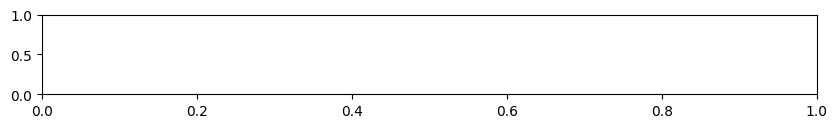

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
import os

# ---------------------------
# Helper: load EEG from MAT
# ---------------------------
def load_sample_eeg(matfile="/content/drive/MyDrive/Neuroinfo_Assignment/sampleEEGdata.mat"):
    """
    Try to load MATLAB sampleEEGdata.mat which contains an EEG struct with fields:
      EEG.data (channels x time x trials), EEG.srate, EEG.times (optional)
    If loading/parsing fails, return synthetic data and a default srate.
    """
    if not os.path.exists(matfile):
        print(f"MAT file '{matfile}' not found — using synthetic EEG.")
        # synthetic EEG: sum of sinusoids + noise
        eeg_srate = 250.0
        tlen = 2.0  # seconds
        eeg_times = np.arange(0, tlen, 1.0 / eeg_srate)
        eeg_data = 10*np.sin(2*np.pi*10*eeg_times) + 3*np.sin(2*np.pi*20*eeg_times) + 2*np.random.randn(len(eeg_times))
        # reshape to channels x time x trials -> make 1 channel, 1 trial
        data = eeg_data[np.newaxis, :, np.newaxis]
        return {'data': data, 'srate': eeg_srate, 'times': eeg_times}

    mat = loadmat(matfile, squeeze_me=True, struct_as_record=False)
    # Try to find EEG variable
    if 'EEG' in mat:
        EEG = mat['EEG']
        # Structure might vary; try common forms:
        try:
            data = np.asarray(EEG.data)  # often shape channels x time x trials
            srate = float(EEG.srate)
            times = np.asarray(EEG.times) if hasattr(EEG, 'times') else np.arange(data.shape[1]) / srate
            print(f"Loaded EEG from {matfile}: data shape {data.shape}, srate {srate} time {times.shape}")
            return {'data': data, 'srate': srate, 'times': times}
        except Exception as e:
            print("Could not parse EEG struct automatically:", e)
    # fallback
    print("No usable EEG variable found in MAT file — using synthetic EEG.")
    eeg_srate = 250.0
    tlen = 2.0
    eeg_times = np.arange(0, tlen, 1.0 / eeg_srate)
    eeg_data = 10*np.sin(2*np.pi*10*eeg_times) + 3*np.sin(2*np.pi*20*eeg_times) + 2*np.random.randn(len(eeg_times))
    data = eeg_data[np.newaxis, :, np.newaxis]
    return {'data': data, 'srate': eeg_srate, 'times': eeg_times}

# ---------------------------
# Load EEG (or synthetic)
# ---------------------------
EEG = load_sample_eeg("/content/drive/MyDrive/Neuroinfo_Assignment/sampleEEGdata.mat")
data = EEG['data'][0,:,0]
#print(data.shape)       # channels x time x trials
srate = EEG['srate']
times = EEG['times']

# Define frequencies (2 to 30 Hz in 5 steps)
frequencies = np.linspace(2, 30, 5)

# Container for wavelets
wavelet_family = []

plt.figure(figsize=(10,6))

for fi, f in enumerate(frequencies):
    # Morlet wavelet = complex sine * Gaussian
    sine_wave = np.exp(2j*np.pi*f*times)
    s = 6/(2*np.pi*f)   # width parameter
    gaussian_win = np.exp(-times**2/(2*s**2))
    wavelet = sine_wave * gaussian_win

    wavelet_family.append(wavelet)

    # Plot (real part for visualization)
    plt.subplot(5,1,fi+1)
    plt.plot(time, np.real(wavelet))
    plt.title(f"Morlet wavelet, {f:.1f} Hz")
    plt.ylabel("Amplitude")
    plt.grid(True)

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()


### Chapter 13 - Inclass Assignments

srate:1000; frequency:10; time-points: (2000,) and s: 0.09549296585513721


'\nfunction w = morlet_wavelet(f0, m, t)\n    sigma = m / (2*pi*f0);\n    w = exp(2*1i*pi*f0*t) .* exp(-t.^2/(2*sigma^2));\n    w = w ./ sqrt(sum(abs(w).^2)) / sqrt(sigma); % normalize energy and scale\n'

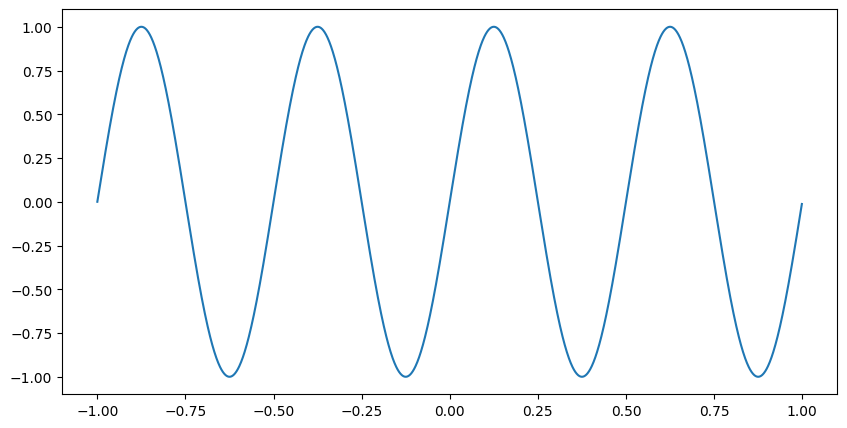

In [ ]:
# Load the necessary libraries by running the Library cell
#-----------------------
# Figure 13.1
#-------------------------

# parameters...
wavelet_no = 35
srate = 1000 #sampling rate in Hz
f     = 10 # frequency of wavelet in Hz
time  = np.arange(-1,1,1/srate); # time, from -1 to 1 second in steps of 1/sampling-rate
s     = 6/(2*np.pi*f);
signal_30 = np.sin(2*np.pi*2*time)
signal_75 = np.sin(2*np.pi*4*time)
signal_100 = np.sin(2*np.pi*6*time)

print(f"srate:{srate}; frequency:{f}; time-points: {time.shape} and s: {s}")

plt.figure(figsize=(10,5))
plt.plot(time, signal_30)

# and together they make a wavelet
"""
function w = morlet_wavelet(f0, m, t)
    sigma = m / (2*pi*f0);
    w = exp(2*1i*pi*f0*t) .* exp(-t.^2/(2*sigma^2));
    w = w ./ sqrt(sum(abs(w).^2)) / sqrt(sigma); % normalize energy and scale
"""

### Chapter 14 - Hilbert Function

[Library Cell](#scrollTo=QIwoo5ckwreI&line=1&uniqifier=1)

The number of time points=  1001


/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


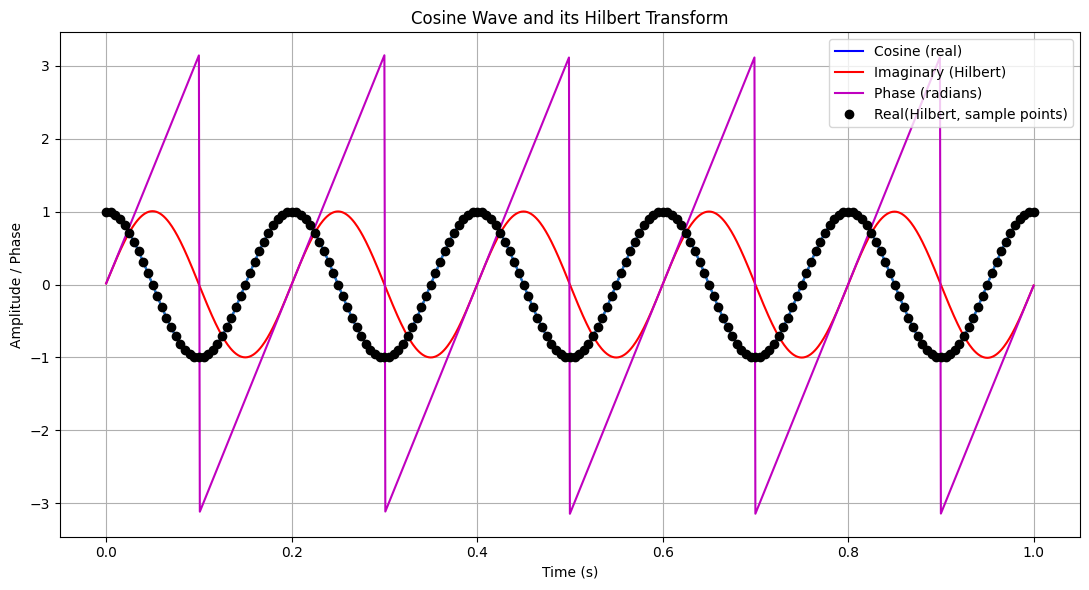

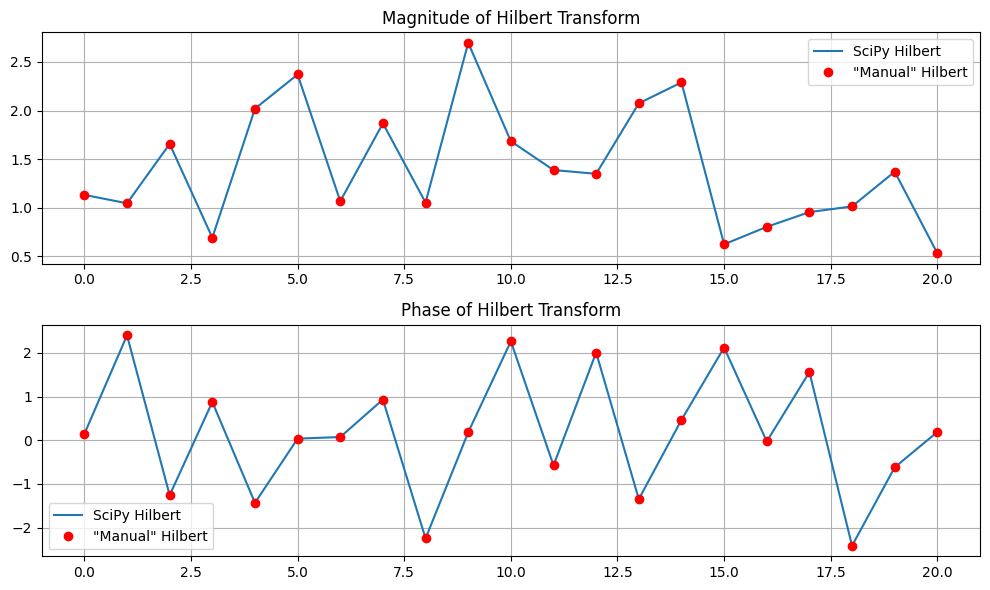

In [ ]:
time   = np.arange(0, 1.001, 0.001);
cosine = np.cos(2*np.pi*5*time);

print("The number of time points= ",time.size)
#print(cosine.size)

# =========================================
# COMPUTE HILBERT TRANSFORM
# =========================================
analytic_signal = hilbert(cosine)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.angle(analytic_signal)
imag_part = np.imag(analytic_signal)
real_part = np.real(analytic_signal)

# =========================================
# PLOT RESULTS
# =========================================
plt.figure(figsize=(11,6))
plt.plot(time, cosine, 'b', label='Cosine (real)')
plt.plot(time, analytic_signal)
plt.plot(time, imag_part, 'r', label='Imaginary (Hilbert)')          # imaginary part
plt.plot(time, instantaneous_phase, 'm', label='Phase (radians)')  # phase
plt.plot(time[::5], real_part[::5], 'ko', label='Real(Hilbert, sample points)')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude / Phase')
plt.title('Cosine Wave and its Hilbert Transform')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# ============================================
# 1. Generate random numbers
# ============================================
n = 21
randomnumbers = np.random.randn(n)

# ============================================
# 2. Take FFT
# ============================================
f = np.fft.fft(randomnumbers)

# create a copy multiplied by the complex operator (i)
complexf = 1j * f

# ============================================
# 3. Find indices of positive and negative frequencies
# ============================================
# MATLAB is 1-indexed, Python is 0-indexed — adjust accordingly
if n % 2 == 0:  # even n
    posF = np.arange(1, n//2)
    negF = np.arange(n//2 + 1, n)
else:  # odd n
    posF = np.arange(1, (n//2) + 1)
    negF = np.arange((n//2) + 1, n)

# ============================================
# 4. Rotate Fourier coefficients
# ============================================
f[posF] = f[posF] + -1j * complexf[posF]
f[negF] = f[negF] +  1j * complexf[negF]

# Alternative faster method (equivalent to above)
# f[posF] = f[posF] * 2
# f[negF] = f[negF] * 0

# ============================================
# 5. Inverse FFT to get Hilbert transform
# ============================================
hilbertx = np.fft.ifft(f)

# ============================================
# 6. Compare with SciPy’s Hilbert transform
# ============================================
hilbertm = hilbert(randomnumbers)

# ============================================
# 7. Plot results
# ============================================
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(np.abs(hilbertm), label='SciPy Hilbert')
plt.plot(np.abs(hilbertx), 'ro', label='"Manual" Hilbert')
plt.legend()
plt.title('Magnitude of Hilbert Transform')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.angle(hilbertm), label='SciPy Hilbert')
plt.plot(np.angle(hilbertx), 'ro', label='"Manual" Hilbert')
plt.legend()
plt.title('Phase of Hilbert Transform')
plt.grid(True)

plt.tight_layout()
plt.show()

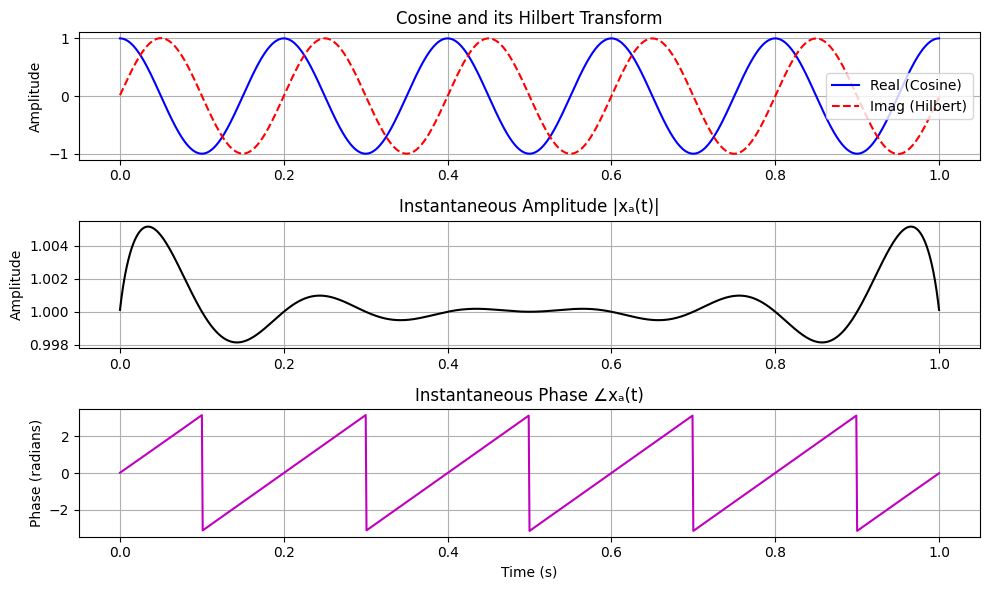

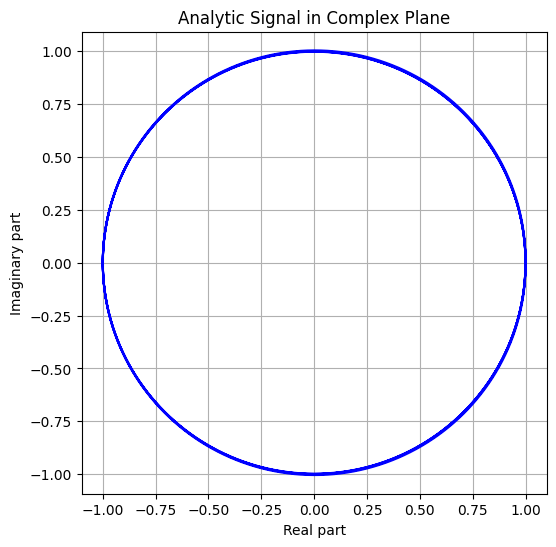

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(time, cosine, 'b', label='Real (Cosine)')
plt.plot(time, imag_part, 'r--', label='Imag (Hilbert)')
plt.title('Cosine and its Hilbert Transform')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, amplitude_envelope, 'k')
plt.title('Instantaneous Amplitude |xₐ(t)|')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, instantaneous_phase, 'm')
plt.title('Instantaneous Phase ∠xₐ(t)')
plt.xlabel('Time (s)')
plt.ylabel('Phase (radians)')
plt.grid(True)

plt.tight_layout()
plt.show()

# ============================================
# STEP 4: COMPLEX PLANE TRAJECTORY (ARGAND DIAGRAM)
# ============================================
plt.figure(figsize=(6, 6))
plt.plot(real_part, imag_part, 'b')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Analytic Signal in Complex Plane')
plt.axis('equal')
plt.grid(True)
plt.show()

[Library Cell](#scrollTo=QIwoo5ckwreI&line=1&uniqifier=1)

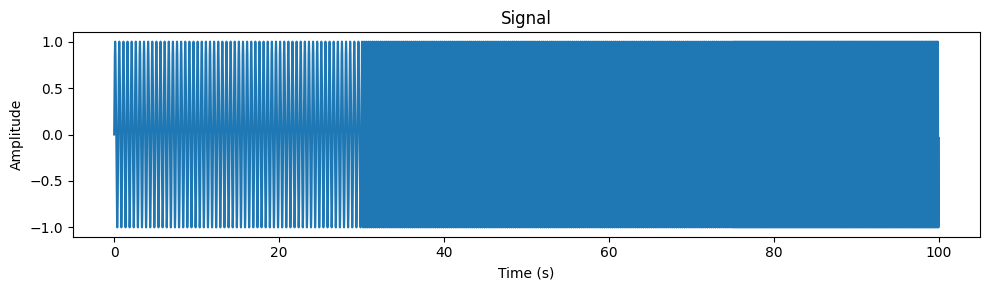

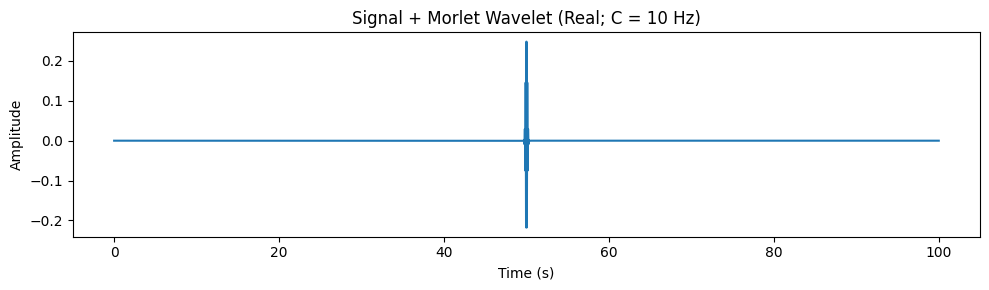

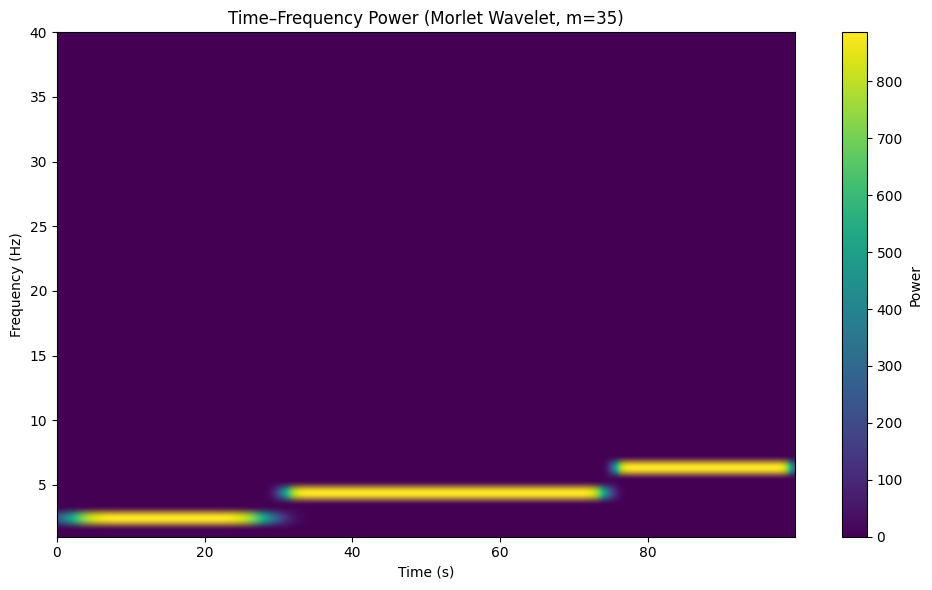

In [ ]:
# ====================================
# PARAMETERS
# ====================================
m = 35                # Wavelet number (controls time-frequency tradeoff)
fs = 1000             # Sampling frequency (Hz)
t = np.arange(0, 100, 1/fs)  # Time vector (0–100 s)

# ====================================
# CREATE SIGNAL
# ====================================
signal = np.zeros_like(t)

signal[t <= 30] = np.sin(2 * np.pi * 2 * t[t <= 30])                # 0–30 s → 2 Hz
signal[(t > 30) & (t <= 75)] = np.sin(2 * np.pi * 4 * t[(t > 30) & (t <= 75)])  # 30–75 s → 4 Hz
signal[t > 75] = np.sin(2 * np.pi * 6 * t[t > 75])                  # 75–100 s → 6 Hz

# ====================================
# PLOT ORIGINAL SIGNAL
# ====================================
plt.figure(figsize=(10, 3))
plt.plot(t, signal)
plt.title('Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# ====================================
# DEFINE MORLET WAVELET FUNCTION
# ====================================
def morlet_wavelet(f0, m, t):
    """Generates a complex Morlet wavelet centered at frequency f0."""
    sigma = m / (2 * np.pi * f0)
    w = np.exp(2j * np.pi * f0 * t) * np.exp(-t**2 / (2 * sigma**2))
    # Normalize: energy and scale
    w = w / np.sqrt(np.sum(np.abs(w)**2)) / np.sqrt(sigma)
    return w

# ====================================
# PLOT EXAMPLE WAVELET
# ====================================
w = morlet_wavelet(10, 6, t - np.mean(t))

plt.figure(figsize=(10, 3))
plt.plot(t, np.real(w))
plt.title('Signal + Morlet Wavelet (Real; C = 10 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# ====================================
# TIME-FREQUENCY ANALYSIS
# ====================================
freqs = np.arange(1, 41, 1)       # 1–40 Hz
power = np.zeros((len(freqs), len(t)))

for i, f in enumerate(freqs):
    sigma = m / (2 * np.pi * f)
    tw = np.arange(-6*sigma, 6*sigma, 1/fs)  # time window for wavelet
    w = morlet_wavelet(f, m, tw)
    conv_res = np.convolve(signal, w, mode='same')
    power[i, :] = np.abs(conv_res)**2

# ====================================
# PLOT TIME-FREQUENCY POWER
# ====================================
plt.figure(figsize=(10, 6))
plt.imshow(power, aspect='auto', extent=[t[0], t[-1], freqs[0], freqs[-1]],
           origin='lower', cmap='viridis')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Time–Frequency Power (Morlet Wavelet, m=35)')
plt.colorbar(label='Power')
plt.tight_layout()
plt.show()


## 07/11/2025 -  Power Spectrum Analysis

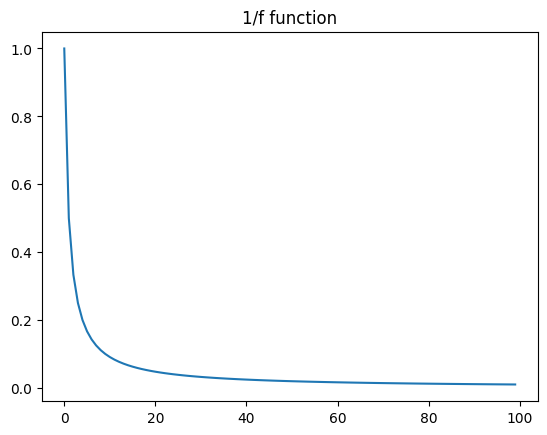

In [ ]:
c, x = 1, 1
plt.figure()
plt.plot(c / (np.arange(1, 101) ** x))
plt.title("1/f function")
plt.show()

In [ ]:
def eeg_data_loader( path: str, channels=None, tmin=None, tmax=None, trials=None, time_units: str = "ms", preload: bool = True ):
  """
    Load EEG and optionally subset by channels, time window, and trials.

    Parameters
    ----------
    path : str
        Path to EEG file. Supported:
        - 'sampleEEGdata.mat' style (Mike X Cohen): EEG.data (chan x time x trials),
          EEG.srate, EEG.times (ms), EEG.chanlocs.labels
        - FIF/EDF/SET via MNE (if installed): continuous or epoched
    channels : None | str | int | list[str|int]
        Channel name(s) or 0-based index(es). None => all channels.
    tmin, tmax : float | None
        Time window to extract. Units given by `time_units` ('ms' or 's').
        None => full duration.
    trials : None | int | list[int]
        Trial index or list (0-based). None => all trials.
        For continuous recordings, a single "trial" dimension of length 1 is returned.
    time_units : {'ms','s'}
        Units for tmin/tmax. For Mike Cohen .mat, times are in ms by default.
    preload : bool
        Relevant for MNE readers.

    Returns
    -------
    data : np.ndarray, shape (n_channels, n_times, n_trials)
    info : dict with keys:
        'srate' (float), 'times' (np.ndarray, in ms),
        'ch_names' (list[str]), 'path' (str), 'units' ('uV' if known or None)
  """
  ext = os.path.splitext(path)[1].lower()

  if ext == ".mat":
    # --- Matlab Data structure ---
    mat = loadmat(path, squeeze_me=True, struct_as_record=False)
    if "EEG" not in mat:
      raise ValueError("Expected 'EEG' struct in .mat file.")

    # ----------- Loading EEG key from MAT dict file -------------
    EEG = mat["EEG"]
    data = np.asarray(EEG.data)  # (chan, time, trials)
    srate = float(EEG.srate)
    times_ms = np.asarray(EEG.times, dtype=float)  # already ms
    # channel labels
    # MATLAB struct can be array with .labels:
    chs = EEG.chanlocs
    if hasattr(chs, "labels"):
        ch_names = [str(l) for l in chs.labels]  # some files store as np.str_
    else:
        # some files: array of structs
        ch_names = [str(c.labels) for c in np.ravel(chs)]

    # --- select channels ---
    ch_inds = _resolve_channel_indices(channels, ch_names)

    # --- select time window ---
    if tmin is None:
        tidx0 = 0
    else:
        tmin_ms = tmin * (1000 if time_units == "s" else 1)
        tidx0 = int(np.argmin(np.abs(times_ms - tmin_ms)))
    if tmax is None:
        tidx1 = len(times_ms) - 1
    else:
        tmax_ms = tmax * (1000 if time_units == "s" else 1)
        tidx1 = int(np.argmin(np.abs(times_ms - tmax_ms)))
    if tidx1 < tidx0:
        tidx0, tidx1 = tidx1, tidx0

    # --- select trials ---
    if trials is None:
        tr_inds = slice(None)
    else:
        tr_inds = _as_index_list(trials, max_len=data.shape[2])

    # slice and ensure (ch, time, trials)
    out = np.asarray(data)[ch_inds, tidx0 : tidx1 + 1, tr_inds]
    # ensure 3D
    out = _ensure_3d(out, axis_order=(0, 1, 2))

    info = dict(
        srate=srate,
        times=times_ms[tidx0 : tidx1 + 1],
        ch_names=[ch_names[i] for i in _to_list(ch_inds, data.shape[0])],
        path=path,
        units="uV",  # typical for this dataset
    )
    return out, info

  # ---------- MNE-backed formats ----------
  if not _HAVE_MNE:
      raise RuntimeError(
          f"Reading {ext} requires MNE. Install with `pip install mne`."
      )

  if ext == ".fif":
      raw = mne.io.read_raw_fif(path, preload=preload, verbose="ERROR")
      return _from_mne_raw(raw, channels, tmin, tmax, time_units, path)
  elif ext in (".edf", ".bdf", ".gdf"):
      raw = mne.io.read_raw_edf(path, preload=preload, verbose="ERROR")
      return _from_mne_raw(raw, channels, tmin, tmax, time_units, path)
  elif ext == ".set":
      raw = mne.io.read_raw_eeglab(path, preload=preload, verbose="ERROR")
      return _from_mne_raw(raw, channels, tmin, tmax, time_units, path)
  else:
      raise ValueError(f"Unsupported file extension: {ext}")


# ================================================
# Internal Helper Functions
# ================================================

def _resolve_channel_indices(channels, ch_names):
    """Return indices from channels=None/str/int/list."""
    n = len(ch_names)
    if channels is None:
        return slice(None)
    if isinstance(channels, (int, np.integer)):
        return [int(channels)]
    if isinstance(channels, str):
        # case-insensitive exact match first
        try:
            return [next(i for i, nm in enumerate(ch_names) if nm.lower() == channels.lower())]
        except StopIteration:
            # fallback: substring match(s)
            inds = [i for i, nm in enumerate(ch_names) if channels.lower() in nm.lower()]
            if not inds:
                raise ValueError(f"Channel '{channels}' not found.")
            return inds
    # list-like of names/indices
    inds = []
    for c in channels:
        if isinstance(c, (int, np.integer)):
            inds.append(int(c))
        else:
            try:
                inds.append(next(i for i, nm in enumerate(ch_names) if nm.lower() == str(c).lower()))
            except StopIteration:
                raise ValueError(f"Channel '{c}' not found.")
    # bounds check
    if any(i < 0 or i >= n for i in inds):
        raise IndexError("Channel index out of range.")
    return inds


def _as_index_list(idx, max_len):
    if isinstance(idx, (int, np.integer)):
        if idx < 0 or idx >= max_len:
            raise IndexError("Trial index out of range.")
        return [int(idx)]
    # assume iterable
    lst = [int(i) for i in idx]
    if any(i < 0 or i >= max_len for i in lst):
        raise IndexError("Trial index out of range.")
    return lst


def _ensure_3d(a, axis_order=(0, 1, 2)):
    """Force array to (C, T, R)."""
    a = np.asarray(a)
    if a.ndim == 1:
        a = a[np.newaxis, :, np.newaxis]
    elif a.ndim == 2:
        a = a[:, :, np.newaxis]
    elif a.ndim > 3:
        raise ValueError("Expected <= 3D array after slicing.")
    return a


def _to_list(x, max_len):
    if isinstance(x, slice):
        return list(range(max_len))[x]
    return list(x)


def _from_mne_raw(raw, channels, tmin, tmax, time_units, path):
    """Return (ch, time, trials=1) from an MNE Raw."""
    # pick channels
    ch_names = raw.ch_names
    inds = _resolve_channel_indices(channels, ch_names)
    if isinstance(inds, slice):
        pick_names = ch_names[inds]
    else:
        pick_names = [ch_names[i] for i in inds]
    raw_picked = raw.copy().pick(pick_names)

    # time window
    sfreq = float(raw_picked.info["sfreq"])
    t0 = 0.0 if tmin is None else (tmin if time_units == "s" else tmin / 1000.0)
    t1 = raw_picked.times[-1] if tmax is None else (tmax if time_units == "s" else tmax / 1000.0)
    t0, t1 = float(t0), float(t1)
    if t1 < t0:
        t0, t1 = t1, t0

    # get data and crop
    raw_picked.crop(tmin=t0, tmax=t1)
    dat, times_s = raw_picked.get_data(return_times=True)  # (ch, time)
    times_ms = times_s * 1000.0

    # shape -> (ch, time, trials=1)
    dat = dat[:, :, np.newaxis]
    info = dict(
        srate=sfreq,
        times=times_ms,
        ch_names=pick_names,
        path=path,
        units=None,  # unit meta often not present; could be V or uV depending on reader
    )
    return dat, info

In [ ]:
data_path = r"/content/drive/MyDrive/Neuroinfo_Assignment/sampleEEGdata.mat"
data, info = eeg_data_loader(data_path,
                      channels=22,    # or ['Fz','Cz'] or 22
                      time_units="ms",
                      trials=[0])
print(data.shape)  # (n_channels, n_times, n_trials)
print(info["srate"], "Hz")
print(info["ch_names"])

min_freq, max_freq, freq_gap = 2, 128, 30
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), freq_gap)
wavelet_cycles = 4
time = np.arange(-1, 1, 1/srate)
half_wave = int((len(time)-1)/2)

n_wavelet = len(time)
n_data = len(signal)
n_convolution = n_wavelet + n_data - 1
n_conv_pow2 = int(2 ** np.ceil(np.log2(n_convolution)))

(1, 640, 1)
256.0 Hz
['P7']


In [ ]:
print(np.log10(2))

0.3010299956639812


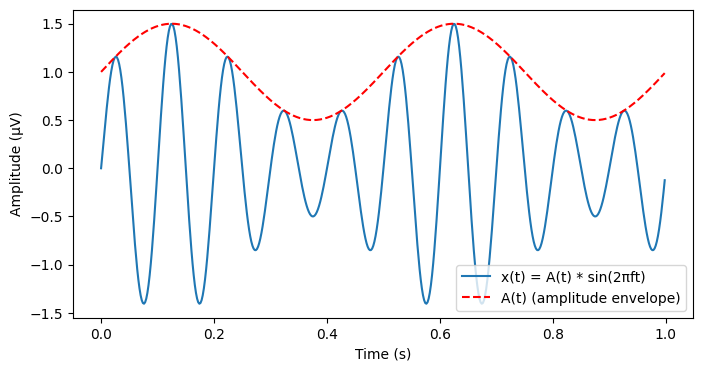

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fs = 500
t = np.arange(0, 1, 1/fs)

# Envelope (slow 2 Hz oscillation)
A = 1 + 0.5*np.sin(2*np.pi*2*t)

# Carrier (fast 10 Hz oscillation)
f = 10
x = A * np.sin(2*np.pi*f*t)

plt.figure(figsize=(8,4))
plt.plot(t, x, label='x(t) = A(t) * sin(2πft)')
plt.plot(t, A, 'r--', label='A(t) (amplitude envelope)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.show()


In [ ]:
# ===============================================================
# Basic Wavelet convolution
# ===============================================================

mat = loadmat(data_path, squeeze_me=True, struct_as_record=False)
EEG = mat["EEG"]

data = EEG.data              # shape: (chan, time, trials)
times = EEG.times            # in ms
srate = float(EEG.srate)
chan = 22                    # channel index (0-based, 23rd = FCz)
signal = data[chan, :, 0]

min_freq, max_freq, num_frex = 2, 128, 30
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)
wavelet_cycles = 4
time = np.arange(-1, 1, 1/srate)
half_wave = int((len(time)-1)/2)

n_wavelet = len(time)
n_data = len(signal)
n_convolution = n_wavelet + n_data - 1
n_conv_pow2 = int(2 ** np.ceil(np.log2(n_convolution)))

fft_data = fft(signal, n_conv_pow2)
tf_data = np.zeros((num_frex, n_data))

for fi, f in enumerate(frequencies):
    s = wavelet_cycles / (2*np.pi*f)
    wavelet = (np.pi*f*np.sqrt(np.pi))**-0.5 * np.exp(2j*np.pi*f*time) * np.exp(-time**2/(2*s**2)) / f
    fft_wavelet = fft(wavelet, n_conv_pow2)
    conv_res = ifft(fft_wavelet * fft_data)[:n_convolution]
    conv_res = conv_res[half_wave:-half_wave]
    tf_data[fi, :] = np.abs(conv_res)**2

ytickskip = np.arange(1, num_frex, 4)
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
lims = [(0,5000), (0,800), (0,25), (-4,4)]
titles = ['0–5000','0–800','0–25','log10']
for i,(lim,ttl) in enumerate(zip(lims,titles)):
    im = ax.flat[i].imshow(
        np.log10(tf_data) if i==3 else tf_data,
        aspect='auto', origin='lower',
        extent=[times[0], times[-1], 0, num_frex],
        vmin=lim[0], vmax=lim[1])
    ax.flat[i].set_title(ttl)
plt.tight_layout(); plt.show()

ValueError: could not broadcast input array from shape (641,) into shape (640,)

## 31/10/2025

In [ ]:
# ---- helper functions -----------------------------------------------------
def find_closest_index(arr, value):
    """Return index of element in arr closest to value."""
    return int(np.argmin(np.abs(arr - value)))

def channel_index_by_label(chanlabel, chanlocs):
    """Return boolean mask or index for channel label lookup.
    chanlocs could be a list/array of dicts or a structured numpy array.
    """
    # Try common structures:
    try:
        labels = [c['labels'][0] if isinstance(c['labels'], np.ndarray) else c['labels'] for c in chanlocs]
    except Exception:
        try:
            labels = [c['labels'][0][0] for c in chanlocs]  # sometimes nested
        except Exception:
            # If chanlocs is simple list of strings:
            labels = list(chanlocs)
    labels = [str(l) for l in labels]
    mask = np.array([lbl.lower() == chanlabel.lower() for lbl in labels])
    # If single index wanted, return integer
    if mask.sum() == 1:
        return np.where(mask)[0][0]
    return mask


/tmp/ipython-input-1709522738.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  srate = float(g('srate'))     # sampling rate in Hz


IndexError: index 243 is out of bounds for axis 0 with size 1

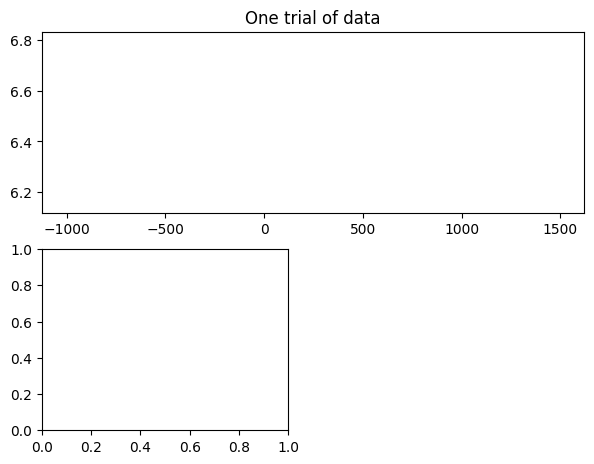

In [ ]:
# ---- load data ------------------------------------------------------------
#mat = loadmat('sampleEEGdata.mat', struct_as_record=False, squeeze_me=True)
#EEG = mat.get('EEG', None)
#if EEG is None:
    # try other common names
    #EEG = mat

EEG = MATdata['EEG'][0, 0]

# Try to extract commonly named fields (robust to struct vs dict)
def g(field):
    # EEG might be a numpy structured object or dict
  return EEG[field]

data = g('data')              # expected shape: (channels, times, trials)
srate = float(g('srate'))     # sampling rate in Hz
times = np.array(g('times'))  # in ms
chanlocs = g('chanlocs')      # channel infos

n_ch, n_times, n_trials = data.shape

# ---------------- Figure 15.1 ----------------------------------------------
timewin = 500.0  # ms

# convert ms to index (round to nearest sample count)
timewinidx = int(round(timewin / (1000.0 / srate)))

# create hann taper function (same as MATLAB .5*(1-cos(...)))
hann_win = 0.5 * (1.0 - np.cos(2.0 * np.pi * np.arange(timewinidx) / (timewinidx - 1)))

# detrend data (useful to attenuate super-low freq artifacts)
# MATLAB used channel 20, trial 16: EEG.data(20,:,16)
# Python indexing zero-based:
chan_idx = 19
trial_idx = 15
d = detrend(data[chan_idx, :, trial_idx])

plt.figure(figsize=(7, 8))
plt.subplot(3, 1, 1)
plt.plot(times, d[0])
plt.title('One trial of data')

# find time index closest to -50 ms
stime = find_closest_index(times, -50)

plt.subplot(3, 2, 3)  # subplot(323) in matlab -> 3 rows, 2 cols, 3rd plot (left middle)
t_range = np.arange(stime, stime + timewinidx)
plt.plot(times[t_range], d[t_range], label='raw')
plt.plot(times[t_range], d[t_range] * hann_win, 'r', label='windowed')
plt.xlim([-50, -50 + timewin])
plt.title('One short-time window of data, windowed')
plt.legend()

# FFT of windowed segment
dwin = d[stime:stime + timewinidx] * hann_win
dfft = np.fft.fft(dwin)
f = np.linspace(0, srate / 2.0, int(np.floor(len(hann_win) / 2)) + 1)

plt.subplot(3, 1, 3)
ps = np.abs(dfft[1:int(np.floor(len(hann_win) / 2)) + 1]) ** 2
plt.plot(f[1:], ps, '.-')
plt.title('power spectrum from that time window')
plt.xlim([1, 128])
# MATLAB set y-limits; here we let matplotlib auto-scale but mimic if desired:
# plt.ylim([-1000, 25000])
plt.xticks(np.arange(0, srate / 2.0 + 1, 10))



### Sample Entropy (SampEn)

In [ ]:
def sample_entropy(signal, m=2, r=0.2):
    """Compute Sample Entropy (SampEn) of a 1D signal."""
    N = len(signal)
    r *= np.std(signal)
    def _phi(m):
        X = np.array([signal[i:i+m] for i in range(N - m + 1)])
        C = np.sum(np.abs(X[:, None] - X[None, :]).max(axis=2) <= r, axis=0) - 1
        return np.sum(C) / (N - m + 1)
    return -np.log(_phi(m+1) / _phi(m))


sampen_val = sample_entropy(eeg, m=2, r=0.2)
print(f"Sample Entropy: {sampen_val:.4f}")

### Permutation Entropy (PermEn)

In [ ]:
from itertools import permutations

def permutation_entropy(signal, m=3, tau=1):
    """Compute Permutation Entropy of a 1D signal."""
    n = len(signal)
    patterns = list(permutations(range(m)))
    c = {p: 0 for p in patterns}
    for i in range(n - tau*(m-1)):
        window = signal[i:(i + tau*m):tau]
        order = tuple(np.argsort(window))
        c[order] += 1
    counts = np.array(list(c.values()), dtype=float)
    p = counts / np.sum(counts)
    p = p[p > 0]
    H = -np.sum(p * np.log(p))
    return H / np.log(len(patterns))  # normalized [0,1]


permen_val = permutation_entropy(eeg, m=3, tau=1)
print(f"Permutation Entropy: {permen_val:.4f}")

### Spectral Entropy (SpecEn)

In [ ]:
def spectral_entropy(signal, fs, method='welch', nperseg=None):
    """Compute spectral entropy using Welch's method."""
    freqs, psd = welch(signal, fs=fs, nperseg=nperseg)
    psd_norm = psd / np.sum(psd)
    H = -np.sum(psd_norm * np.log(psd_norm))
    return H / np.log(len(psd_norm))  # normalized [0,1]


specen_val = spectral_entropy(eeg, fs)
print(f"Spectral Entropy: {specen_val:.4f}")

### Parameter Sensitivity Plots

In [ ]:
r_vals = np.linspace(0.05, 0.4, 8)
samp_vals = [sample_entropy(eeg, m=2, r=r) for r in r_vals]

plt.plot(r_vals, samp_vals, 'o-')
plt.xlabel("r (fraction of std)")
plt.ylabel("Sample Entropy")
plt.title("Sensitivity of SampEn to tolerance r")
plt.show()

m_vals = range(3, 8)
perm_vals = [permutation_entropy(eeg, m=m) for m in m_vals]

plt.plot(m_vals, perm_vals, 'o-')
plt.xlabel("Embedding dimension m")
plt.ylabel("Permutation Entropy")
plt.title("Sensitivity of PermEn to m")
plt.show()

### Electric Fields from EEG Data

#### Loading EEG dataset

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Load EEG data from .edf file
raw = mne.io.read_raw_edf('data.edf', preload=True)

# Display basic info
print(raw.info)
print(f"Sampling rate: {raw.info['sfreq']} Hz")
print(f"Number of channels: {len(raw.ch_names)}")
print(f"Channel names: {raw.ch_names}")
print(f"Data shape: {raw.get_data().shape}")

# Extract data: shape (n_channels, n_samples)
data = raw.get_data()
times = raw.times

#### Electrode Positioning and Preprocessing

In [ ]:
# =========================================
# SETTING ELECTRODE POSITIONS
# =========================================

# Use standard 10-20 montage (most common)
montage = mne.channels.make_standard_montage('standard_1020')

# or load from file if custom
# montage = mne.channels.read_montage('custom_montage.txt')

# Apply to raw data
raw.set_montage(montage)

# Verify electrode positions
raw.plot_sensors(show_names=True)
plt.show()

# Access 3D coordinates (shape: n_channels x 3)
electrode_positions = raw.info['dig'][1:]  # Skip fiducials
print(f"Electrode positions shape: {len(electrode_positions)} channels")


# ============================================
# PREPROCESSING OF EEG DATA
#=============================================

# Bandpass filter to remove artifacts and noise
raw.filter(l_freq=1, h_freq=50, method='fir')

# Notch filter for line noise
raw.notch_filter(freqs=50)  # or 60 Hz for 60 Hz systems

# Re-reference to average (important for field computation)
raw.set_eeg_reference('average')

# Detect and interpolate bad channels
raw.info['bads'] = ['Fp1']  # if needed
raw.interpolate_bads(reset_bads=True)


#### Computing Spatial Gradient

1. Current Source Density (CSD) – Laplacian

In [ ]:
from mne.preprocessing import compute_current_source_density

# Compute CSD (Laplacian reference)
csd_data = compute_current_source_density(raw, lambda2=1e-5, n_jobs=1)

# or manually using spherical spline
from mne.preprocessing import mne.EEG

raw_csd = raw.copy()
raw_csd = mne.preprocessing.compute_current_source_density(raw_csd)

# CSD data is in same shape as raw: (n_channels, n_samples)
print(f"CSD data shape: {csd_data.shape}")

# Plot CSD topography at a specific time point
t_idx = 500  # time sample
csd_at_t = csd_data[:, t_idx]

# Plot as scalp topography
fig, ax = plt.subplots()
mne.viz.plot_topomap(csd_at_t, raw.info, axes=ax, show=True)


2. Direct Spatial Gradient (Finite Differences)

In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance_matrix

# Get electrode 3D positions
pos_3d = np.array([raw.info['chs'][i]['loc'][:3] for i in range(len(raw.ch_names))])

# Project to 2D scalp surface (equidistant or stereographic)
from mne.viz._topomap import _get_pos_2d
pos_2d = _get_pos_2d(raw.info, picks=None)

# Compute distance matrix
dist_matrix = distance_matrix(pos_2d, pos_2d)

# For each time sample, compute gradient via Laplacian weights
n_channels = len(raw.ch_names)
n_samples = raw.get_data().shape[1]
gradient_x = np.zeros((n_channels, n_samples))
gradient_y = np.zeros((n_channels, n_samples))

for ch_idx in range(n_channels):
    # Find k nearest neighbors
    k = 4
    neighbors = np.argsort(dist_matrix[ch_idx])[:k+1]

    # Weighted least-squares gradient at channel ch_idx
    # (simplified; full implementation uses robust methods)

    # Approximate: gradient ~ mean of neighbor differences
    neighbor_data = raw.get_data()[neighbors, :]
    center_data = raw.get_data(picks=ch_idx)[0, :]

    gradient_x[ch_idx, :] = np.mean(neighbor_data - center_data, axis=0)
    gradient_y[ch_idx, :] = gradient_x[ch_idx, :]  # Simplified

print(f"Gradient shape: {gradient_x.shape}")

3. Spherical Spline Interpolation

In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance_matrix

# Get electrode 3D positions
pos_3d = np.array([raw.info['chs'][i]['loc'][:3] for i in range(len(raw.ch_names))])

# Project to 2D scalp surface (equidistant or stereographic)
from mne.viz._topomap import _get_pos_2d
pos_2d = _get_pos_2d(raw.info, picks=None)

# Compute distance matrix
dist_matrix = distance_matrix(pos_2d, pos_2d)

# For each time sample, compute gradient via Laplacian weights
n_channels = len(raw.ch_names)
n_samples = raw.get_data().shape[1]
gradient_x = np.zeros((n_channels, n_samples))
gradient_y = np.zeros((n_channels, n_samples))

for ch_idx in range(n_channels):
    # Find k nearest neighbors
    k = 4
    neighbors = np.argsort(dist_matrix[ch_idx])[:k+1]

    # Weighted least-squares gradient at channel ch_idx
    # (simplified; full implementation uses robust methods)

    # Approximate: gradient ~ mean of neighbor differences
    neighbor_data = raw.get_data()[neighbors, :]
    center_data = raw.get_data(picks=ch_idx)[0, :]

    gradient_x[ch_idx, :] = np.mean(neighbor_data - center_data, axis=0)
    gradient_y[ch_idx, :] = gradient_x[ch_idx, :]  # Simplified

print(f"Gradient shape: {gradient_x.shape}")


#### Visualizing Electric Field Topography (EFT)

In [ ]:
# Select time window of interest (e.g., 500 ms after stimulus)
t_idx = 500  # sample index
t_value = raw.times[t_idx]

# Extract potential at this time across all channels
V_snapshot = raw.get_data()[:, t_idx]

# or CSD if computed
E_snapshot = raw_csd_clean.get_data()[:, t_idx]

# Plot potential field
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Potential topography
im1 = mne.viz.plot_topomap(
    V_snapshot,
    raw.info,
    axes=ax1,
    show=False,
    vmin=-10, vmax=10,  # Colorbar limits in µV
    cmap='RdBu_r'
)
ax1.set_title(f'Potential at t={t_value:.3f}s')

# CSD/Electric field topography
im2 = mne.viz.plot_topomap(
    E_snapshot,
    raw.info,
    axes=ax2,
    show=False,
    cmap='RdBu_r'
)
ax2.set_title(f'Electric Field (CSD) at t={t_value:.3f}s')

plt.colorbar(im1, ax=ax1, label='Potential (µV)')
plt.colorbar(im2, ax=ax2, label='CSD (µA/mm²)')
plt.tight_layout()
plt.show()
